### Members
***
+ UID: 805861373, name: Sinya Peng
+ UID: 205928946, name: Yu-Wei Chen
+ UID: 405928672, name: Po-Yen Yang (Paul Yang)
+ UID: 705946207, name: Chen-Wei Huang

In [1]:
%matplotlib inline

import datetime
import math
import os
import os.path
import random
from collections import Counter, defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimr
import torch.utils.data as Data
import tqdm  # for progress bar
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from matplotlib.pyplot import figure
from torch import Tensor
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
from torchvision import datasets, transforms

# cuda
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # set gpu device

In [2]:
# torch
torch.multiprocessing.set_start_method("spawn", force=True)
torch.backends.cudnn.deterministic = True

# matplotlib
plt.rcParams["figure.dpi"] = 500
plt.rcParams["figure.figsize"] = [26, 50]

fsize = 15
tsize = 9
tdir = "in"
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use("default")
# plt.rcParams['text.usetex'] = True
plt.rcParams["font.size"] = fsize
plt.rcParams["legend.fontsize"] = tsize
plt.rcParams["xtick.direction"] = tdir
plt.rcParams["ytick.direction"] = tdir
plt.rcParams["xtick.major.size"] = major
plt.rcParams["xtick.minor.size"] = minor
plt.rcParams["ytick.major.size"] = 5.0
plt.rcParams["ytick.minor.size"] = 3.0
plt.rcParams["axes.linewidth"] = lwidth
plt.rcParams["legend.handlelength"] = lhandle

In [3]:
# See https://pytorch.org/docs/stable/notes/cuda.html
print(torch.cuda.is_available())
device_id = (
    0 if torch.cuda.is_available() else "cpu"
)  # Equivalent to device_id = 'cuda:0'
device = torch.device(device_id)  # use these semantics to specify a specific device.

True


In [4]:
# Set the random seeds.
# Sometimes some operations are not deterministic.
# See https://pytorch.org/docs/stable/notes/randomness.html
#   and https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html
SEED = 806
torch.manual_seed(SEED)  # set the random seed for pytorch
random.seed(SEED)  # just in case
np.random.seed(SEED)  # just in case

In [5]:
data_dir = "/home/ray080186/eceC247/final_project/data"
X_test = np.load(os.path.join(data_dir, "X_test.npy"))
y_test = np.load(os.path.join(data_dir, "y_test.npy"))
person_test = np.load(os.path.join(data_dir, "person_test.npy")).squeeze(axis=1)
X_train_valid = np.load(os.path.join(data_dir, "X_train_valid.npy"))
y_train_valid = np.load(os.path.join(data_dir, "y_train_valid.npy"))
person_train_valid = np.load(os.path.join(data_dir, "person_train_valid.npy")).squeeze(
    axis=1
)

n_class = len(set(y_train_valid))
min_y = min(y_train_valid)
y_train_valid = y_train_valid - min_y
y_test = y_test - min_y

# Draw Figure

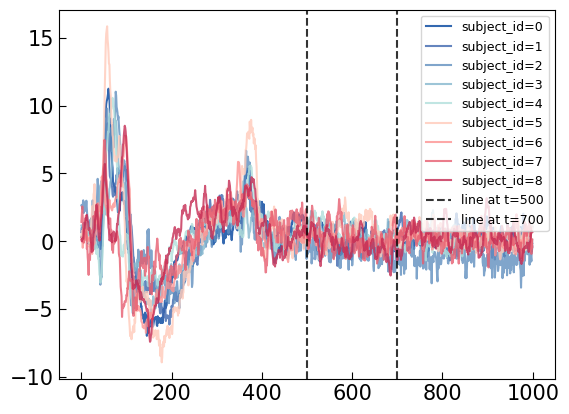

In [6]:
colors = [
    "#00429d",
    "#3e67ae",
    "#618fbf",
    "#85b7ce",
    "#b1dfdb",
    "#ffcab9",
    "#fd9291",
    "#e75d6f",
    "#c52a52",
    "#93003a",
]


## Visualizing the data
for subject_id in range(9):
    s_indices = [i for i, s in enumerate(person_train_valid) if s == subject_id]
    X_train_valid_s, y_train_valid_s = (
        X_train_valid[s_indices],
        y_train_valid[s_indices],
    )

    avg_train_valid_s = np.mean(X_train_valid_s[:, 8, :], axis=0)

    plt.plot(
        np.arange(1000),
        avg_train_valid_s,
        label=f"{subject_id=}",
        alpha=0.8,
        color=colors[subject_id],
    )

plt.axvline(x=500, label="line at t=500", alpha=0.8, linestyle="--", color="black")
plt.axvline(x=700, label="line at t=700", alpha=0.8, linestyle="--", color="black")

plt.legend()
plt.show()

# Prepare Data

In [7]:
def data_prep(X, y, sub_sample, average, noise, time_step=500):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:, :, 0:time_step]
    print("Shape of X after trimming:", X.shape)

    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y
    print("Shape of X after maxpooling:", total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average), axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print("Shape of X after averaging+noise and concatenating:", total_X.shape)

    # Subsampling
    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + (
            np.random.normal(0.0, 0.5, X[:, :, i::sub_sample].shape) if noise else 0.0
        )

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))

    print("Shape of X after subsampling and concatenating:", total_X.shape)
    return total_X, total_y

In [8]:
print("Training/Valid data shape: {}".format(X_train_valid.shape))
print("Test data shape: {}".format(X_test.shape))
print("Training/Valid target shape: {}".format(y_train_valid.shape))
print("Test target shape: {}".format(y_test.shape))
print("Person train/valid shape: {}".format(person_train_valid.shape))
print("Person test shape: {}".format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115,)
Person test shape: (443,)


In [9]:
Counter(person_test)

Counter({0.0: 50,
         1.0: 50,
         2.0: 50,
         3.0: 50,
         4.0: 47,
         5.0: 49,
         6.0: 50,
         7.0: 50,
         8.0: 47})

In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        if isinstance(X, np.ndarray):
            self.X = torch.FloatTensor(X)  # 32-bit float
        else:
            self.X = X
        if isinstance(Y, np.ndarray):
            self.Y = torch.LongTensor(Y)  # integer type
        else:
            self.Y = Y
        return

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [11]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


s0_indices = [i for i, s in enumerate(person_train_valid) if s == 0]
X_train_valid_s0, y_train_valid_s0 = (
    X_train_valid[s0_indices],
    y_train_valid[s0_indices],
)

s0_test_indices = [i for i, s in enumerate(person_test) if s == 0]
X_test_s0, y_test_s0 = X_test[s0_test_indices], y_test[s0_test_indices]

X_test_person = []
y_test_person = []

## Preprocessing the dataset
X_train, y_train = data_prep(X_train, y_train, 2, 2, True)
X_valid, y_valid = data_prep(X_valid, y_valid, 2, 2, True)
X_test_prep, y_test_prep = data_prep(X_test, y_test, 2, 2, True)
X_train_valid_s0, y_train_valid_s0 = data_prep(
    X_train_valid_s0, y_train_valid_s0, 2, 2, True
)
X_test_s0, y_test_s0 = data_prep(X_test_s0, y_test_s0, 2, 2, True)

for subject_id in range(9):
    s_test_indices = [i for i, s in enumerate(person_test) if s == subject_id]
    X_test_s, y_test_s = X_test_prep[s_test_indices], y_test_prep[s_test_indices]
    X_test_person.append(X_test_s)
    y_test_person.append(y_test_s)

print("Shape of testing set:", X_test_prep.shape)
print("Shape of testing labels:", y_test_prep.shape)

print("Shape of training set:", X_train.shape)
print("Shape of validation set:", X_valid.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation labels:", y_valid.shape)

print("Shape of s0 training set:", X_train_valid_s0.shape)
print("Shape of s0 training labels:", y_train_valid_s0.shape)


X_train = torch.FloatTensor(X_train).to(device)
X_valid = torch.FloatTensor(X_valid).to(device)
X_test_prep = torch.FloatTensor(X_test_prep).to(device)
X_train_valid_s0 = torch.FloatTensor(X_train_valid_s0).to(device)
X_test_s0 = torch.FloatTensor(X_test_s0).to(device)

y_train = torch.LongTensor(y_train).to(device)
y_valid = torch.LongTensor(y_valid).to(device)
y_test_prep = torch.LongTensor(y_test_prep).to(device)
y_train_valid_s0 = torch.LongTensor(y_train_valid_s0).to(device)
y_test_s0 = torch.LongTensor(y_test_s0).to(device)

for subject_id in range(9):
    X_test_person[subject_id] = torch.FloatTensor(X_test_person[subject_id]).to(device)
    y_test_person[subject_id] = torch.LongTensor(y_test_person[subject_id]).to(device)

Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of X after trimming: (237, 22, 500)
Shape of X after maxpooling: (237, 22, 250)
Shape of X after averaging+noise and concatenating: (474, 22, 250)
Shape of X after subsampling and concatenating: (948, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatena

In [12]:
batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_valid, y_valid)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test_prep, y_test_prep)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

person_s0_train_dataset = MyDataset(X_train_valid_s0, y_train_valid_s0)
person_s0_train_dataloader = torch.utils.data.DataLoader(
    person_s0_train_dataset, batch_size, shuffle=False
)

person_s0_test_dataset = MyDataset(X_test_s0, y_test_s0)
person_s0_test_dataloader = torch.utils.data.DataLoader(
    person_s0_test_dataset, batch_size, shuffle=False
)

person_s_test_dataloaders = []

for subject_id in range(9):
    person_s_test_dataset = MyDataset(
        X_test_person[subject_id], y_test_person[subject_id]
    )
    person_s_test_dataloader = torch.utils.data.DataLoader(
        person_s_test_dataset, batch_size, shuffle=False
    )
    person_s_test_dataloaders.append(person_s_test_dataloader)

In [13]:
len(train_dataset), len(train_dataloader)
batch = next(iter(train_dataloader))
images, label = batch
print(images.shape, label.shape)

torch.Size([64, 22, 250]) torch.Size([64])


# Model Train Pipeline

In [14]:
def model_train(model, train_data, num_epochs, optimizer, use_scheduler=True):
    print(model)
    # For weight regularization, add weight_decay=l2_regularization_strength to the optimizer instantiation,
    #   or implement it manually and add it to the loss before backward propagation.

    # Declare an optimizer that handles weight updates
    # This optimizer also has its own state dictionary
    if use_scheduler:
        scheduler = optimr.lr_scheduler.MultiStepLR(
            optimizer, milestones=[800, 1400], gamma=0.5
        )

    celoss = nn.CrossEntropyLoss()

    loss_hist = []
    acc_hist = []
    val_loss_hist = []
    val_acc_hist = []
    test_loss_hist = []
    test_acc_hist = []
    person_s0_acc_hist = []
    max_val_acc = 0
    max_test_acc = 0
    max_person_s0_acc = 0
    max_person_s_acc = defaultdict(int)

    # progress bar
    pbar = tqdm.tqdm(
        range(num_epochs),
        position=0,
        leave=True,
        bar_format="{l_bar}{bar:10}{r_bar}",
    )
    for epoch in pbar:

        model.train()  # set model to training mode.
        for batch in train_data:
            optimizer.zero_grad()  # clear gradients of parameters that optimizer is optimizing
            x, y = batch

            # x = x.to(device) # necessary if X is not on the same device as model
            # y = y.to(device)
            # print(x.shape)
            x = x.unsqueeze(1)

            out = model(x)  # shape (batch_size, n_classes)
            loss = celoss(out, y)  # calculate the cross entropy loss

            loss.backward()  # backpropagate
            optimizer.step()  # perform optimization step
            if use_scheduler:
                scheduler.step()
            # IMPORTANT: DO NOT store 'loss' by itself, since it references its entire computational graph.
            # Otherwise you will run out of memory.
            # You MUST use .item() to convert to a scalar or call .detach().
            loss_hist.append(loss.item())

        model.eval()  # set model to evaluation mode. Relevant for dropout, batchnorm, layernorm, etc.
        # calculate accuracy for training and validation sets
        ns = 0  # number of samples
        nc = 0  # number of correct outputs
        with torch.no_grad():
            for batch in train_data:
                x, y = batch
                x = x.unsqueeze(1)
                out = model(x)
                ns += len(y)
                nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
        acc_hist.append(nc / ns)

        ns = 0  # number of samples
        nc = 0  # number of correct outputs

        with torch.no_grad():
            for batch in val_dataloader:
                x, y = batch

                x = x.unsqueeze(1)
                out = model(x)
                loss = celoss(out, y)
                val_loss_hist.append(loss.item())
                ns += len(y)
                nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
        val_acc_hist.append(nc / ns)
        if val_acc_hist[-1] > max_val_acc:
            max_val_acc = val_acc_hist[-1]

        ns = 0  # number of samples
        nc = 0  # number of correct outputs

        with torch.no_grad():
            for batch in test_dataloader:
                x, y = batch

                x = x.unsqueeze(1)
                out = model(x)
                loss = celoss(out, y)
                test_loss_hist.append(loss.item())
                ns += len(y)
                nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
        test_acc_hist.append(nc / ns)
        if test_acc_hist[-1] > max_test_acc:
            max_test_acc = test_acc_hist[-1]

        ns = 0  # number of samples
        nc = 0  # number of correct outputs

        with torch.no_grad():
            for batch in person_s0_test_dataloader:
                x, y = batch

                x = x.unsqueeze(1)
                out = model(x)
                loss = celoss(out, y)
                person_s0_acc_hist.append(loss.item())
                ns += len(y)
                nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
        person_s0_acc_hist.append(nc / ns)
        if person_s0_acc_hist[-1] > max_person_s0_acc:
            max_person_s0_acc = person_s0_acc_hist[-1]

        for subject_id in range(9):
            person_s_test_dataloader = person_s_test_dataloaders[subject_id]
            ns = 0  # number of samples
            nc = 0  # number of correct outputs

            with torch.no_grad():
                for batch in person_s_test_dataloader:
                    x, y = batch

                    x = x.unsqueeze(1)
                    out = model(x)
                    loss = celoss(out, y)
                    ns += len(y)
                    nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
            if nc / ns > max_person_s_acc[subject_id]:
                max_person_s_acc[subject_id] = nc / ns

        # update progress bar postfix
        pbar.set_postfix(
            {
                "max_test_acc": max_test_acc,
                "max_person_s0_acc": max_person_s0_acc,
                "acc": acc_hist[-1],
                "val_acc": val_acc_hist[-1],
                "test_acc": test_acc_hist[-1],
                "person_s0_acc": person_s0_acc_hist[-1],
                "max_val_acc": max_val_acc,
            }
        )

    print(f"{max_person_s0_acc=}")
    print(f"{max_test_acc=}")
    for subject_id in range(9):
        print(f"max_person_s{subject_id}_acc = {max_person_s_acc[subject_id]}")

    plt.figure(dpi=100)
    plt.plot(loss_hist, label="training")
    plt.yscale("log")
    plt.ylabel("loss")
    plt.legend(loc="lower left")
    plt.xlabel("step (training)")
    plt.twiny()
    plt.plot(val_loss_hist, "r", label="validation")
    plt.plot(test_loss_hist, "r", label="test", color="orange")
    plt.xlabel("step (validation)")
    plt.legend(loc="upper left")

    plt.figure(dpi=100)
    plt.plot(acc_hist, label="training accuracy")
    plt.plot(val_acc_hist, label="validation accuracy")
    plt.plot(test_acc_hist, label="test accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.grid()

# Define Model

In [15]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False
            ),
            nn.BatchNorm2d(
                16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            # nn.ELU(alpha=0.1),
            # nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=0.25),
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(
                32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False
            ),
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            # nn.ELU(alpha=0.1),
            # nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=0.25),
        )
        self.classify = nn.Sequential(
            nn.Linear(in_features=4704, out_features=4, bias=True)
        )

    def forward(self, x):
        # batch size, in_channel, height, weight
        # print(x.shape)
        # print(":DD")
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        # print(x.shape)
        # [4, 4704]
        x = x.view(x.size(0), -1)
        # print(x.shape)

        x = self.classify(x)
        return x

In [16]:
C = 22
T = 1000
N = 4


class DeepConvNet(nn.Module):
    def __init__(self):
        super(DeepConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                1, 25, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(25, 25, kernel_size=(C, 1), padding=(0, 2), bias=True),
            nn.BatchNorm2d(
                25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            # nn.ELU(alpha=0.1),
            # nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                25, 50, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.BatchNorm2d(
                50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            # nn.ELU(alpha=0.1),
            # nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0),
            nn.Dropout(p=0.5),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                50, 100, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.BatchNorm2d(
                100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            # nn.ELU(alpha=0.1),
            # nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), padding=0),
            nn.Dropout(p=0.5),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(
                100, 200, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.BatchNorm2d(
                200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            # nn.ELU(alpha=0.1),
            # nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), padding=0),
            nn.Dropout(p=0.5),
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=3000, out_features=4, bias=True),
        )

    def forward(self, x):
        # print(x.shape)
        # print(":DD")
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.classify(x)
        return x

In [17]:
class NaiveLSTM(nn.Module):
    def __init__(self):
        super(NaiveLSTM, self).__init__()
        self.lstm = nn.Sequential(
            nn.LSTM(
                input_size=22,
                hidden_size=256,
                batch_first=True,
                bias=True,
                bidirectional=True,
            ),
        )

        self.classify = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=4, bias=True),
        )

    def forward(self, x):
        #         print(":D")
        #         print(x.shape)

        x = x.squeeze(1)

        #         print(x.shape)

        x = x.permute(0, 2, 1)
        packed_output, (hidden_state, cell_state) = self.lstm(x)

        # Concatenating the final forward and backward hidden states
        hidden = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)
        dense_outputs = self.classify(hidden)

        return dense_outputs

In [18]:
class CNNLSTM(nn.Module):
    def __init__(
        self,
        output_size=4,
        use_attention=False,
        lstm_hidden_size=128,
        lstm_layer_size=1,
    ):
        super(CNNLSTM, self).__init__()

        self.use_attention = use_attention
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_layer_size = lstm_layer_size

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 11)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(22, 1)),
            nn.AvgPool2d(kernel_size=(1, 3)),
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 11)),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(1, 3)),
            nn.Dropout(p=0.6),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 11)),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(1, 3)),
            nn.Dropout(p=0.6),
        )

        self.fc1 = nn.Linear(128, 128)

        self.lstm = nn.LSTM(
            128,
            lstm_hidden_size,
            num_layers=lstm_layer_size,
            bidirectional=True,
            batch_first=False,
        )
        if use_attention:
            self.fc_attn = nn.Linear(lstm_hidden_size * 2, lstm_layer_size * 2)

        self.dropout = nn.Dropout(p=0.5)
        self.classify = nn.Linear(lstm_hidden_size * 2, output_size)

    def forward(self, x):
        # CNN
        # x = self.cnn(x.unsqueeze(1))
        x = self.cnn(x)
        x = x.transpose(1, 3).flatten(start_dim=2)

        # lstm
        x = self.fc1(x).transpose(0, 1)
        lstm_output, (hiddens, _) = self.lstm(x)
        lstm_output = lstm_output.permute(1, 0, 2)
        final_hidden = hiddens.view(self.lstm_layer_size, 2, -1, self.lstm_hidden_size)[
            -1
        ]
        final_hidden = torch.cat((final_hidden[0], final_hidden[1]), 1)

        # attention
        if self.use_attention:
            attn_weights = self.fc_attn(lstm_output)
            attn_weights = torch.bmm(attn_weights, final_hidden.unsqueeze(2))
            attn_weights = F.softmax(attn_weights.squeeze(2), 1)
            final_hidden = torch.bmm(
                lstm_output.transpose(1, 2), attn_weights.unsqueeze(2)
            ).squeeze(2)

        # mlp
        output = self.classify(self.dropout(final_hidden))
        return output

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[: x.size(0), :]

In [20]:
class NaiveTransformer(nn.Module):
    def __init__(self, feature_size=250, num_layers=2, dropout=0.5):
        super(NaiveTransformer, self).__init__()
        self.model_type = "Transformer"

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_size, dim_feedforward=512, nhead=10, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_layers
        )
        self.decoder = nn.Linear(feature_size * 22, 4, bias=True)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # print(":D")
        # print(src.shape)
        # print(":D")
        src = src.squeeze(1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = output.view([-1, output.shape[2] * output.shape[1]])
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

In [21]:
class CNNPlus(nn.Module):
    def __init__(self):
        super(CNNPlus, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(16, 32, kernel_size=(22, 1), padding=(0, 2), bias=True),
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.4),
            nn.Conv2d(
                32, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0),
            nn.Dropout(p=0.8),
            nn.Conv2d(128, 256, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), padding=0),
            nn.Dropout(p=0.4),
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=7168, out_features=3584, bias=True),
            nn.Linear(3584, 1792),
            nn.Linear(1792, 4),
        )

    def forward(self, x):
        # batch size, in_channel, height, weight
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.classify(x)
        return x

In [22]:
model = NaiveLSTM().to(device)
summary(
        model,
        input_size=(64, 1, 22, 250),
        depth=5,
        col_names=[
            "input_size",
            "output_size",
            "num_params",
        ],
        col_width=16,
        verbose=1,
        row_settings=("depth", "var_names", "ascii_only"),
    )

Layer (type (var_name):depth-idx)        Input Shape      Output Shape     Param #
NaiveLSTM (NaiveLSTM)                    [64, 1, 22, 250] [64, 4]          --
+ Sequential (lstm): 1-1                 [64, 250, 22]    [64, 250, 512]   --
|    + LSTM (0): 2-1                     [64, 250, 22]    [64, 250, 512]   573,440
+ Sequential (classify): 1-2             [64, 512]        [64, 4]          --
|    + Dropout (0): 2-2                  [64, 512]        [64, 512]        --
|    + Linear (1): 2-3                   [64, 512]        [64, 4]          2,052
Total params: 575,492
Trainable params: 575,492
Non-trainable params: 0
Total mult-adds (G): 9.18
Input size (MB): 1.41
Forward/backward pass size (MB): 65.54
Params size (MB): 2.30
Estimated Total Size (MB): 69.25


Layer (type (var_name):depth-idx)        Input Shape      Output Shape     Param #
NaiveLSTM (NaiveLSTM)                    [64, 1, 22, 250] [64, 4]          --
+ Sequential (lstm): 1-1                 [64, 250, 22]    [64, 250, 512]   --
|    + LSTM (0): 2-1                     [64, 250, 22]    [64, 250, 512]   573,440
+ Sequential (classify): 1-2             [64, 512]        [64, 4]          --
|    + Dropout (0): 2-2                  [64, 512]        [64, 512]        --
|    + Linear (1): 2-3                   [64, 512]        [64, 4]          2,052
Total params: 575,492
Trainable params: 575,492
Non-trainable params: 0
Total mult-adds (G): 9.18
Input size (MB): 1.41
Forward/backward pass size (MB): 65.54
Params size (MB): 2.30
Estimated Total Size (MB): 69.25

In [23]:
model = NaiveTransformer().to(device)
summary(
        model,
        input_size=(64, 1, 22, 250),
        depth=5,
        col_names=[
            "input_size",
            "output_size",
            "num_params",
        ],
        col_width=16,
        verbose=1,
        row_settings=("depth", "var_names", "ascii_only"),
    )

Layer (type (var_name):depth-idx)                            Input Shape      Output Shape     Param #
NaiveTransformer (NaiveTransformer)                          [64, 1, 22, 250] [64, 4]          508,762
+ PositionalEncoding (pos_encoder): 1-1                      [64, 22, 250]    [64, 22, 250]    --
+ TransformerEncoder (transformer_encoder): 1-2              [64, 22, 250]    [64, 22, 250]    --
|    + ModuleList (layers): 2-1                              --               --               --
|    |    + TransformerEncoderLayer (0): 3-1                 [64, 22, 250]    [64, 22, 250]    --
|    |    |    + MultiheadAttention (self_attn): 4-1         [64, 22, 250]    [64, 22, 250]    251,000
|    |    |    + Dropout (dropout1): 4-2                     [64, 22, 250]    [64, 22, 250]    --
|    |    |    + LayerNorm (norm1): 4-3                      [64, 22, 250]    [64, 22, 250]    500
|    |    |    + Linear (linear1): 4-4                       [64, 22, 250]    [64, 22, 512]    128,512

Layer (type (var_name):depth-idx)                            Input Shape      Output Shape     Param #
NaiveTransformer (NaiveTransformer)                          [64, 1, 22, 250] [64, 4]          508,762
+ PositionalEncoding (pos_encoder): 1-1                      [64, 22, 250]    [64, 22, 250]    --
+ TransformerEncoder (transformer_encoder): 1-2              [64, 22, 250]    [64, 22, 250]    --
|    + ModuleList (layers): 2-1                              --               --               --
|    |    + TransformerEncoderLayer (0): 3-1                 [64, 22, 250]    [64, 22, 250]    --
|    |    |    + MultiheadAttention (self_attn): 4-1         [64, 22, 250]    [64, 22, 250]    251,000
|    |    |    + Dropout (dropout1): 4-2                     [64, 22, 250]    [64, 22, 250]    --
|    |    |    + LayerNorm (norm1): 4-3                      [64, 22, 250]    [64, 22, 250]    500
|    |    |    + Linear (linear1): 4-4                       [64, 22, 250]    [64, 22, 512]    128,512

In [24]:
# model = EEGNet().to(device)
# print(summary(model, input_size=(64, 1, 22, 250), depth=5))

model = EEGNet().to(device)
summary(
        model,
        input_size=(64, 1, 22, 250),
        depth=5,
        col_names=[
            "input_size",
            "output_size",
            "num_params",
        ],
        col_width=18,
        verbose=1,
        row_settings=("depth", "var_names", "ascii_only"),
    )

Layer (type (var_name):depth-idx)        Input Shape        Output Shape       Param #
EEGNet (EEGNet)                          [64, 1, 22, 250]   [64, 4]            --
+ Sequential (firstconv): 1-1            [64, 1, 22, 250]   [64, 16, 22, 250]  --
|    + Conv2d (0): 2-1                   [64, 1, 22, 250]   [64, 16, 22, 250]  816
|    + BatchNorm2d (1): 2-2              [64, 16, 22, 250]  [64, 16, 22, 250]  32
+ Sequential (depthwiseConv): 1-2        [64, 16, 22, 250]  [64, 32, 21, 62]   --
|    + Conv2d (0): 2-3                   [64, 16, 22, 250]  [64, 32, 21, 250]  64
|    + BatchNorm2d (1): 2-4              [64, 32, 21, 250]  [64, 32, 21, 250]  64
|    + ReLU (2): 2-5                     [64, 32, 21, 250]  [64, 32, 21, 250]  --
|    + AvgPool2d (3): 2-6                [64, 32, 21, 250]  [64, 32, 21, 62]   --
|    + Dropout (4): 2-7                  [64, 32, 21, 62]   [64, 32, 21, 62]   --
+ Sequential (separableConv): 1-3        [64, 32, 21, 62]   [64, 32, 21, 7]    --
|    + Con

Layer (type (var_name):depth-idx)        Input Shape        Output Shape       Param #
EEGNet (EEGNet)                          [64, 1, 22, 250]   [64, 4]            --
+ Sequential (firstconv): 1-1            [64, 1, 22, 250]   [64, 16, 22, 250]  --
|    + Conv2d (0): 2-1                   [64, 1, 22, 250]   [64, 16, 22, 250]  816
|    + BatchNorm2d (1): 2-2              [64, 16, 22, 250]  [64, 16, 22, 250]  32
+ Sequential (depthwiseConv): 1-2        [64, 16, 22, 250]  [64, 32, 21, 62]   --
|    + Conv2d (0): 2-3                   [64, 16, 22, 250]  [64, 32, 21, 250]  64
|    + BatchNorm2d (1): 2-4              [64, 32, 21, 250]  [64, 32, 21, 250]  64
|    + ReLU (2): 2-5                     [64, 32, 21, 250]  [64, 32, 21, 250]  --
|    + AvgPool2d (3): 2-6                [64, 32, 21, 250]  [64, 32, 21, 62]   --
|    + Dropout (4): 2-7                  [64, 32, 21, 62]   [64, 32, 21, 62]   --
+ Sequential (separableConv): 1-3        [64, 32, 21, 62]   [64, 32, 21, 7]    --
|    + Con

In [25]:
# model = DeepConvNet().to(device)
# print(summary(model, input_size=(64, 1, 22, 250), depth=5))

model = DeepConvNet().to(device)
summary(
        model,
        input_size=(64, 1, 22, 250),
        depth=5,
        col_names=[
            "input_size",
            "output_size",
            "num_params",
        ],
        col_width=18,
        verbose=1,
        row_settings=("depth", "var_names", "ascii_only"),
    )

Layer (type (var_name):depth-idx)        Input Shape        Output Shape       Param #
DeepConvNet (DeepConvNet)                [64, 1, 22, 250]   [64, 4]            --
+ Sequential (conv1): 1-1                [64, 1, 22, 250]   [64, 25, 1, 127]   --
|    + Conv2d (0): 2-1                   [64, 1, 22, 250]   [64, 25, 22, 250]  150
|    + Conv2d (1): 2-2                   [64, 25, 22, 250]  [64, 25, 1, 254]   13,775
|    + BatchNorm2d (2): 2-3              [64, 25, 1, 254]   [64, 25, 1, 254]   50
|    + ReLU (3): 2-4                     [64, 25, 1, 254]   [64, 25, 1, 254]   --
|    + MaxPool2d (4): 2-5                [64, 25, 1, 254]   [64, 25, 1, 127]   --
|    + Dropout (5): 2-6                  [64, 25, 1, 127]   [64, 25, 1, 127]   --
+ Sequential (conv2): 1-2                [64, 25, 1, 127]   [64, 50, 1, 63]    --
|    + Conv2d (0): 2-7                   [64, 25, 1, 127]   [64, 50, 1, 127]   6,300
|    + BatchNorm2d (1): 2-8              [64, 50, 1, 127]   [64, 50, 1, 127]   100
| 

Layer (type (var_name):depth-idx)        Input Shape        Output Shape       Param #
DeepConvNet (DeepConvNet)                [64, 1, 22, 250]   [64, 4]            --
+ Sequential (conv1): 1-1                [64, 1, 22, 250]   [64, 25, 1, 127]   --
|    + Conv2d (0): 2-1                   [64, 1, 22, 250]   [64, 25, 22, 250]  150
|    + Conv2d (1): 2-2                   [64, 25, 22, 250]  [64, 25, 1, 254]   13,775
|    + BatchNorm2d (2): 2-3              [64, 25, 1, 254]   [64, 25, 1, 254]   50
|    + ReLU (3): 2-4                     [64, 25, 1, 254]   [64, 25, 1, 254]   --
|    + MaxPool2d (4): 2-5                [64, 25, 1, 254]   [64, 25, 1, 127]   --
|    + Dropout (5): 2-6                  [64, 25, 1, 127]   [64, 25, 1, 127]   --
+ Sequential (conv2): 1-2                [64, 25, 1, 127]   [64, 50, 1, 63]    --
|    + Conv2d (0): 2-7                   [64, 25, 1, 127]   [64, 50, 1, 127]   6,300
|    + BatchNorm2d (1): 2-8              [64, 50, 1, 127]   [64, 50, 1, 127]   100
| 

In [26]:
# model = CNNLSTM().to(device)
# print(summary(model, input_size=(64, 1, 22, 250), depth=5))


model = CNNLSTM().to(device)
summary(
        model,
        input_size=(64, 1, 22, 250),
        depth=5,
        col_names=[
            "input_size",
            "output_size",
            "num_params",
        ],
        col_width=18,
        verbose=1,
        row_settings=("depth", "var_names", "ascii_only"),
    )

Layer (type (var_name):depth-idx)        Input Shape        Output Shape       Param #
CNNLSTM (CNNLSTM)                        [64, 1, 22, 250]   [64, 4]            --
+ Sequential (cnn): 1-1                  [64, 1, 22, 250]   [64, 128, 1, 4]    --
|    + Conv2d (0): 2-1                   [64, 1, 22, 250]   [64, 16, 22, 240]  192
|    + Conv2d (1): 2-2                   [64, 16, 22, 240]  [64, 32, 1, 240]   11,296
|    + AvgPool2d (2): 2-3                [64, 32, 1, 240]   [64, 32, 1, 80]    --
|    + Dropout (3): 2-4                  [64, 32, 1, 80]    [64, 32, 1, 80]    --
|    + Conv2d (4): 2-5                   [64, 32, 1, 80]    [64, 64, 1, 70]    22,592
|    + BatchNorm2d (5): 2-6              [64, 64, 1, 70]    [64, 64, 1, 70]    128
|    + ELU (6): 2-7                      [64, 64, 1, 70]    [64, 64, 1, 70]    --
|    + MaxPool2d (7): 2-8                [64, 64, 1, 70]    [64, 64, 1, 23]    --
|    + Dropout (8): 2-9                  [64, 64, 1, 23]    [64, 64, 1, 23]    --
|

Layer (type (var_name):depth-idx)        Input Shape        Output Shape       Param #
CNNLSTM (CNNLSTM)                        [64, 1, 22, 250]   [64, 4]            --
+ Sequential (cnn): 1-1                  [64, 1, 22, 250]   [64, 128, 1, 4]    --
|    + Conv2d (0): 2-1                   [64, 1, 22, 250]   [64, 16, 22, 240]  192
|    + Conv2d (1): 2-2                   [64, 16, 22, 240]  [64, 32, 1, 240]   11,296
|    + AvgPool2d (2): 2-3                [64, 32, 1, 240]   [64, 32, 1, 80]    --
|    + Dropout (3): 2-4                  [64, 32, 1, 80]    [64, 32, 1, 80]    --
|    + Conv2d (4): 2-5                   [64, 32, 1, 80]    [64, 64, 1, 70]    22,592
|    + BatchNorm2d (5): 2-6              [64, 64, 1, 70]    [64, 64, 1, 70]    128
|    + ELU (6): 2-7                      [64, 64, 1, 70]    [64, 64, 1, 70]    --
|    + MaxPool2d (7): 2-8                [64, 64, 1, 70]    [64, 64, 1, 23]    --
|    + Dropout (8): 2-9                  [64, 64, 1, 23]    [64, 64, 1, 23]    --
|

In [27]:
# model = CNNPlus().to(device)
# print(summary(model, input_size=(64, 1, 22, 250), depth=5))


model = CNNPlus().to(device)
summary(
        model,
        input_size=(64, 1, 22, 250),
        depth=5,
        col_names=[
            "input_size",
            "output_size",
            "num_params",
        ],
        col_width=18,
        verbose=1,
        row_settings=("depth", "var_names", "ascii_only"),
    )

Layer (type (var_name):depth-idx)        Input Shape        Output Shape       Param #
CNNPlus (CNNPlus)                        [64, 1, 22, 250]   [64, 4]            --
+ Sequential (cnn): 1-1                  [64, 1, 22, 250]   [64, 256, 1, 28]   --
|    + Conv2d (0): 2-1                   [64, 1, 22, 250]   [64, 16, 22, 250]  96
|    + Conv2d (1): 2-2                   [64, 16, 22, 250]  [64, 32, 1, 254]   11,296
|    + BatchNorm2d (2): 2-3              [64, 32, 1, 254]   [64, 32, 1, 254]   64
|    + ReLU (3): 2-4                     [64, 32, 1, 254]   [64, 32, 1, 254]   --
|    + AvgPool2d (4): 2-5                [64, 32, 1, 254]   [64, 32, 1, 127]   --
|    + Dropout (5): 2-6                  [64, 32, 1, 127]   [64, 32, 1, 127]   --
|    + Conv2d (6): 2-7                   [64, 32, 1, 127]   [64, 64, 1, 127]   10,304
|    + Conv2d (7): 2-8                   [64, 64, 1, 127]   [64, 128, 1, 123]  41,088
|    + BatchNorm2d (8): 2-9              [64, 128, 1, 123]  [64, 128, 1, 123]  25

Layer (type (var_name):depth-idx)        Input Shape        Output Shape       Param #
CNNPlus (CNNPlus)                        [64, 1, 22, 250]   [64, 4]            --
+ Sequential (cnn): 1-1                  [64, 1, 22, 250]   [64, 256, 1, 28]   --
|    + Conv2d (0): 2-1                   [64, 1, 22, 250]   [64, 16, 22, 250]  96
|    + Conv2d (1): 2-2                   [64, 16, 22, 250]  [64, 32, 1, 254]   11,296
|    + BatchNorm2d (2): 2-3              [64, 32, 1, 254]   [64, 32, 1, 254]   64
|    + ReLU (3): 2-4                     [64, 32, 1, 254]   [64, 32, 1, 254]   --
|    + AvgPool2d (4): 2-5                [64, 32, 1, 254]   [64, 32, 1, 127]   --
|    + Dropout (5): 2-6                  [64, 32, 1, 127]   [64, 32, 1, 127]   --
|    + Conv2d (6): 2-7                   [64, 32, 1, 127]   [64, 64, 1, 127]   10,304
|    + Conv2d (7): 2-8                   [64, 64, 1, 127]   [64, 128, 1, 123]  41,088
|    + BatchNorm2d (8): 2-9              [64, 128, 1, 123]  [64, 128, 1, 123]  25

### Performance of training on all subjects.

In [28]:
models_name = [
    "NaiveLSTM",
    "NaiveTransformer",
    "EEGNet",
    "DeepConvNet",
    "CNNLSTM",
    "CNNPlus",
]

models = {
    "NaiveLSTM": NaiveLSTM().to(device),
    "NaiveTransformer": NaiveTransformer().to(device),
    "EEGNet": EEGNet().to(device),
    "DeepConvNet": DeepConvNet().to(device),
    "CNNLSTM": CNNLSTM().to(device),
    "CNNPlus": CNNPlus().to(device),
}

num_epochs_dict = {
    "NaiveLSTM": 100,
    "NaiveTransformer": 100,
    "EEGNet": 100,
    "DeepConvNet": 100,
    "CNNLSTM": 100,
    "CNNPlus": 100,
}

optimizers_dict = {
    "NaiveLSTM": torch.optim.Adam(
        models["NaiveLSTM"].parameters(), weight_decay=0.00, lr=5e-4
    ),
    "NaiveTransformer": torch.optim.Adam(
        models["NaiveTransformer"].parameters(), weight_decay=0.02, lr=5e-4
    ),
    "EEGNet": torch.optim.Adam(
        models["EEGNet"].parameters(), weight_decay=0.01, lr=5e-4
    ),
    "DeepConvNet": torch.optim.Adam(
        models["DeepConvNet"].parameters(), weight_decay=0.01, lr=5e-4
    ),
    "CNNLSTM": torch.optim.Adam(
        models["CNNLSTM"].parameters(), weight_decay=0.01, lr=5e-4
    ),
    "CNNPlus": torch.optim.Adam(
        models["CNNPlus"].parameters(), weight_decay=0.01, lr=1e-3
    ),
}

use_scheduler_dict = {
    "NaiveLSTM": True,
    "NaiveTransformer": False,
    "EEGNet": True,
    "DeepConvNet": True,
    "CNNLSTM": True,
    "CNNPlus": True,
}

NaiveLSTM(
  (lstm): Sequential(
    (0): LSTM(22, 256, batch_first=True, bidirectional=True)
  )
  (classify): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=4, bias=True)
  )
)
100
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0.0
)
True
NaiveLSTM(
  (lstm): Sequential(
    (0): LSTM(22, 256, batch_first=True, bidirectional=True)
  )
  (classify): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=4, bias=True)
  )
)


100%|██████████| 100/100 [09:00<00:00,  5.40s/it, max_test_acc=0.354, max_person_s0_acc=0.3


max_person_s0_acc=0.38
max_test_acc=0.3538374717832957
max_person_s0_acc = 0.42
max_person_s1_acc = 0.5
max_person_s2_acc = 0.58
max_person_s3_acc = 0.44
max_person_s4_acc = 0.48936170212765956
max_person_s5_acc = 0.2653061224489796
max_person_s6_acc = 0.52
max_person_s7_acc = 0.36
max_person_s8_acc = 0.40425531914893614
NaiveTransformer(
  (pos_encoder): PositionalEncoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=250, out_features=250, bias=True)
    )
    (linear1): Linear(in_features=250, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (linear2): Linear(in_features=512, out_features=250, bias=True)
    (norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
  )
  (transformer_encoder): TransformerEncoder

100%|██████████| 100/100 [02:51<00:00,  1.71s/it, max_test_acc=0.476, max_person_s0_acc=0.5


max_person_s0_acc=0.51
max_test_acc=0.4757336343115124
max_person_s0_acc = 0.54
max_person_s1_acc = 0.48
max_person_s2_acc = 0.54
max_person_s3_acc = 0.44
max_person_s4_acc = 0.6382978723404256
max_person_s5_acc = 0.5510204081632653
max_person_s6_acc = 0.72
max_person_s7_acc = 0.58
max_person_s8_acc = 0.5319148936170213
EEGNet(
  (firstconv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (separableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNo

100%|██████████| 100/100 [03:22<00:00,  2.02s/it, max_test_acc=0.622, max_person_s0_acc=0.6


max_person_s0_acc=0.645
max_test_acc=0.6218961625282167
max_person_s0_acc = 0.68
max_person_s1_acc = 0.62
max_person_s2_acc = 0.72
max_person_s3_acc = 0.72
max_person_s4_acc = 0.7659574468085106
max_person_s5_acc = 0.5918367346938775
max_person_s6_acc = 0.7
max_person_s7_acc = 0.6
max_person_s8_acc = 0.7446808510638298
DeepConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (1): Conv2d(25, 25, kernel_size=(22, 1), stride=(1, 1), padding=(0, 2))
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1

100%|██████████| 100/100 [03:02<00:00,  1.82s/it, max_test_acc=0.726, max_person_s0_acc=0.6


max_person_s0_acc=0.67
max_test_acc=0.7262979683972912
max_person_s0_acc = 0.66
max_person_s1_acc = 0.7
max_person_s2_acc = 0.84
max_person_s3_acc = 0.74
max_person_s4_acc = 0.8297872340425532
max_person_s5_acc = 0.673469387755102
max_person_s6_acc = 0.8
max_person_s7_acc = 0.78
max_person_s8_acc = 0.8297872340425532
CNNLSTM(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 11), stride=(1, 1))
    (1): Conv2d(16, 32, kernel_size=(22, 1), stride=(1, 1))
    (2): AvgPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(1, 11), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ELU(alpha=1.0)
    (7): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.6, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(1, 11), stride=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

100%|██████████| 100/100 [03:20<00:00,  2.00s/it, max_test_acc=0.7, max_person_s0_acc=0.72,


max_person_s0_acc=0.72
max_test_acc=0.7003386004514672
max_person_s0_acc = 0.74
max_person_s1_acc = 0.58
max_person_s2_acc = 0.78
max_person_s3_acc = 0.76
max_person_s4_acc = 0.8297872340425532
max_person_s5_acc = 0.7346938775510204
max_person_s6_acc = 0.76
max_person_s7_acc = 0.7
max_person_s8_acc = 0.8297872340425532
CNNPlus(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (1): Conv2d(16, 32, kernel_size=(22, 1), stride=(1, 1), padding=(0, 2))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
    (5): Dropout(p=0.4, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (7): Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(1, 2), stride=(1

100%|██████████| 100/100 [05:47<00:00,  3.47s/it, max_test_acc=0.731, max_person_s0_acc=0.7


max_person_s0_acc=0.735
max_test_acc=0.7313769751693002
max_person_s0_acc = 0.74
max_person_s1_acc = 0.74
max_person_s2_acc = 0.78
max_person_s3_acc = 0.78
max_person_s4_acc = 0.8297872340425532
max_person_s5_acc = 0.8163265306122449
max_person_s6_acc = 0.84
max_person_s7_acc = 0.78
max_person_s8_acc = 0.8297872340425532


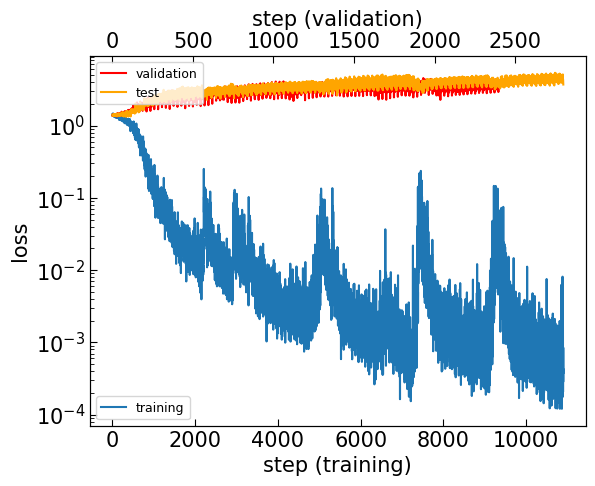

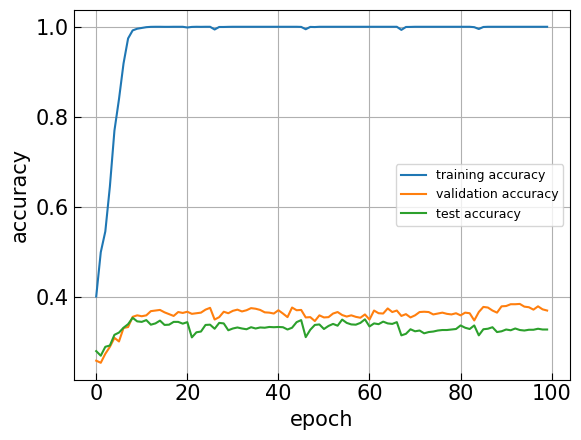

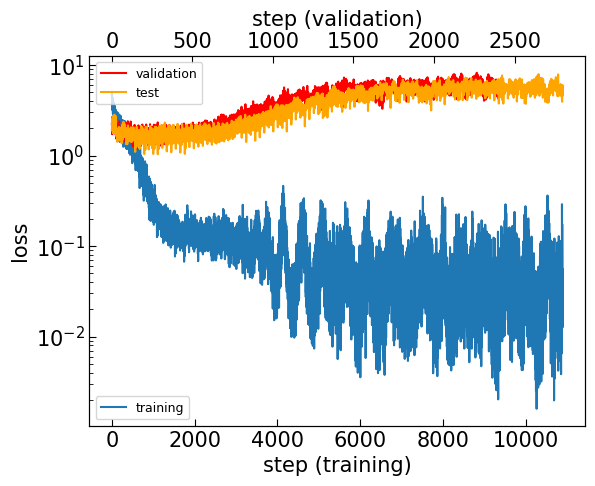

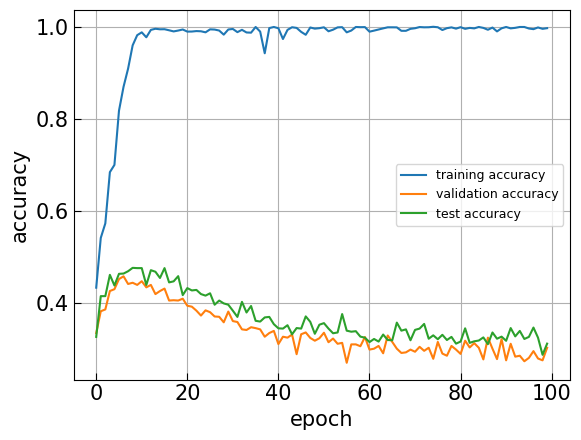

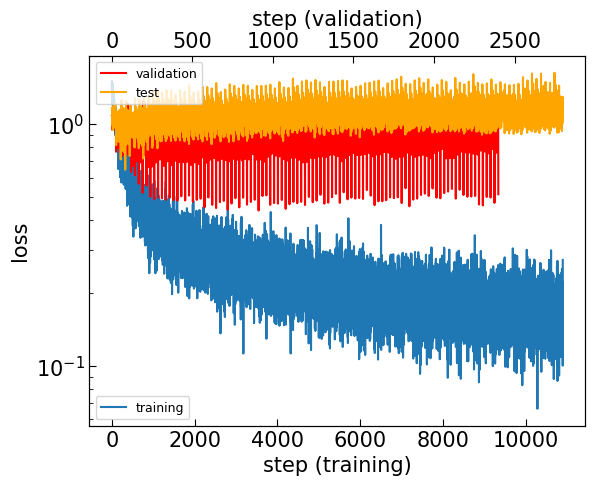

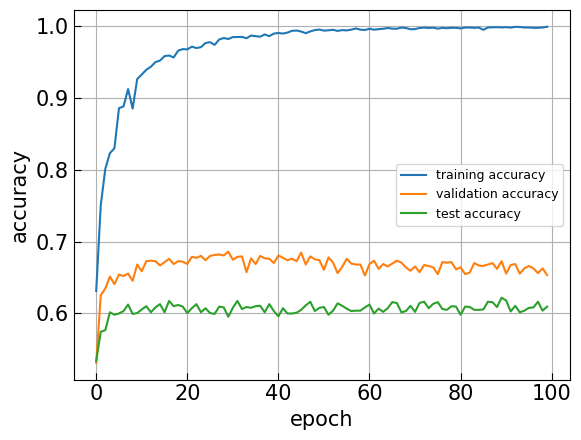

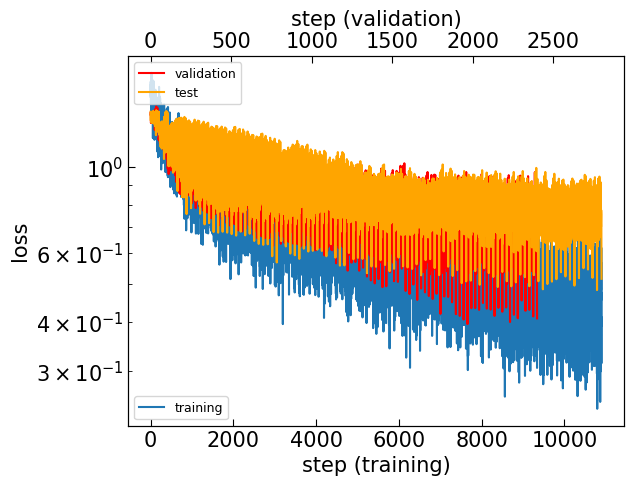

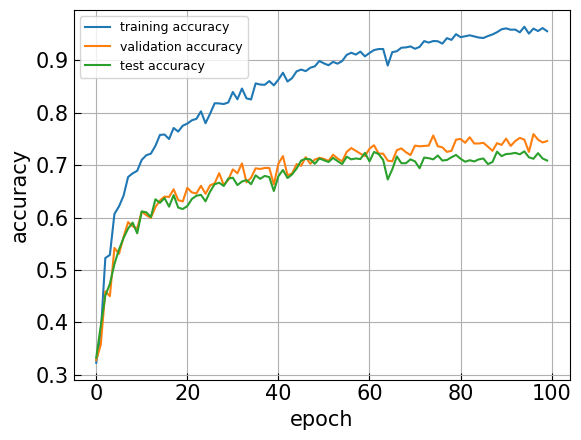

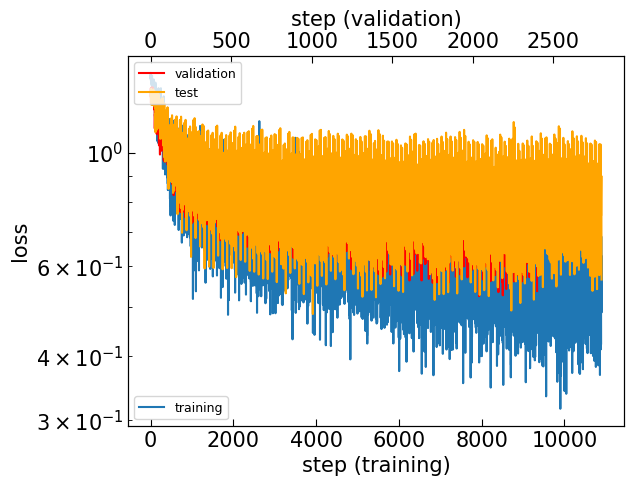

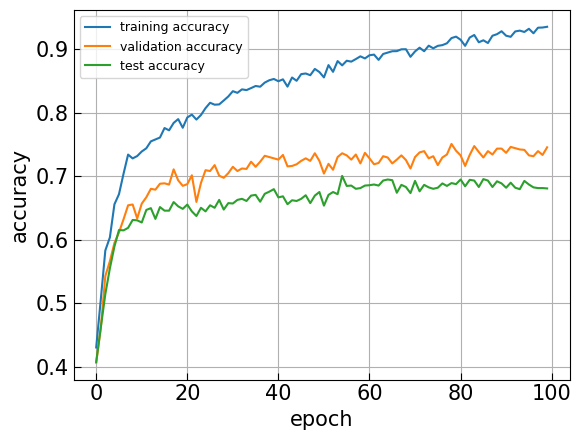

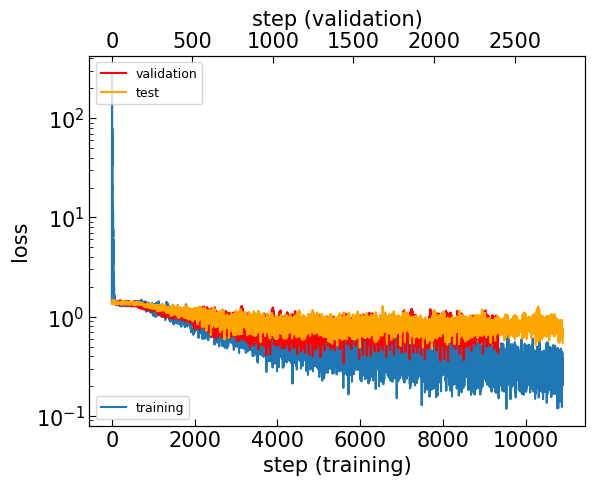

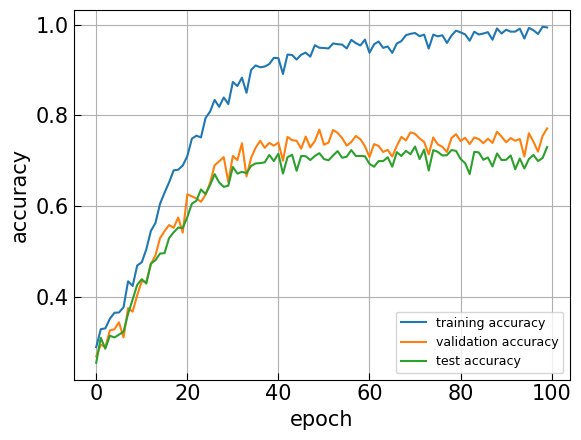

In [29]:
for model in models_name:
    print("=" * 30)
    print(models[model])
    print(num_epochs_dict[model])
    print(optimizers_dict[model])
    print(use_scheduler_dict[model])
    model_train(
        model=models[model],
        train_data=train_dataloader,
        num_epochs=num_epochs_dict[model],
        optimizer=optimizers_dict[model],
        use_scheduler=use_scheduler_dict[model],
    )

### Performance of training on subject one

In [30]:
models_name = [
    "NaiveLSTM",
    "NaiveTransformer",
    "EEGNet",
    "DeepConvNet",
    "CNNLSTM",
    "CNNPlus",
]

models = {
    "NaiveLSTM": NaiveLSTM().to(device),
    "NaiveTransformer": NaiveTransformer().to(device),
    "EEGNet": EEGNet().to(device),
    "DeepConvNet": DeepConvNet().to(device),
    "CNNLSTM": CNNLSTM().to(device),
    "CNNPlus": CNNPlus().to(device),
}

num_epochs_dict = {
    "NaiveLSTM": 100,
    "NaiveTransformer": 100,
    "EEGNet": 100,
    "DeepConvNet": 100,
    "CNNLSTM": 100,
    "CNNPlus": 100,
}

optimizers_dict = {
    "NaiveLSTM": torch.optim.Adam(
        models["NaiveLSTM"].parameters(), weight_decay=0.00, lr=5e-4
    ),
    "NaiveTransformer": torch.optim.Adam(
        models["NaiveTransformer"].parameters(), weight_decay=0.02, lr=5e-4
    ),
    "EEGNet": torch.optim.Adam(
        models["EEGNet"].parameters(), weight_decay=0.01, lr=5e-4
    ),
    "DeepConvNet": torch.optim.Adam(
        models["DeepConvNet"].parameters(), weight_decay=0.01, lr=5e-4
    ),
    "CNNLSTM": torch.optim.Adam(
        models["CNNLSTM"].parameters(), weight_decay=0.01, lr=5e-4
    ),
    "CNNPlus": torch.optim.Adam(
        models["CNNPlus"].parameters(), weight_decay=0.01, lr=1e-3
    ),
}

use_scheduler_dict = {
    "NaiveLSTM": True,
    "NaiveTransformer": False,
    "EEGNet": True,
    "DeepConvNet": True,
    "CNNLSTM": True,
    "CNNPlus": True,
}

NaiveLSTM(
  (lstm): Sequential(
    (0): LSTM(22, 256, batch_first=True, bidirectional=True)
  )
  (classify): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=4, bias=True)
  )
)
100
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0.0
)
True
NaiveLSTM(
  (lstm): Sequential(
    (0): LSTM(22, 256, batch_first=True, bidirectional=True)
  )
  (classify): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=4, bias=True)
  )
)


100%|██████████| 100/100 [02:21<00:00,  1.41s/it, max_test_acc=0.295, max_person_s0_acc=0.3


max_person_s0_acc=0.395
max_test_acc=0.2945823927765237
max_person_s0_acc = 0.42
max_person_s1_acc = 0.36
max_person_s2_acc = 0.36
max_person_s3_acc = 0.42
max_person_s4_acc = 0.2765957446808511
max_person_s5_acc = 0.30612244897959184
max_person_s6_acc = 0.48
max_person_s7_acc = 0.32
max_person_s8_acc = 0.2765957446808511
NaiveTransformer(
  (pos_encoder): PositionalEncoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=250, out_features=250, bias=True)
    )
    (linear1): Linear(in_features=250, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (linear2): Linear(in_features=512, out_features=250, bias=True)
    (norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
  )
  (transformer_encoder): TransformerEncode

100%|██████████| 100/100 [00:47<00:00,  2.11it/s, max_test_acc=0.328, max_person_s0_acc=0.4


max_person_s0_acc=0.45
max_test_acc=0.32844243792325056
max_person_s0_acc = 0.5
max_person_s1_acc = 0.42
max_person_s2_acc = 0.36
max_person_s3_acc = 0.36
max_person_s4_acc = 0.40425531914893614
max_person_s5_acc = 0.42857142857142855
max_person_s6_acc = 0.34
max_person_s7_acc = 0.4
max_person_s8_acc = 0.3617021276595745
EEGNet(
  (firstconv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (separableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchN

100%|██████████| 100/100 [00:46<00:00,  2.15it/s, max_test_acc=0.431, max_person_s0_acc=0.6


max_person_s0_acc=0.6
max_test_acc=0.43115124153498874
max_person_s0_acc = 0.62
max_person_s1_acc = 0.44
max_person_s2_acc = 0.68
max_person_s3_acc = 0.48
max_person_s4_acc = 0.3829787234042553
max_person_s5_acc = 0.42857142857142855
max_person_s6_acc = 0.6
max_person_s7_acc = 0.38
max_person_s8_acc = 0.44680851063829785
DeepConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (1): Conv2d(25, 25, kernel_size=(22, 1), stride=(1, 1), padding=(0, 2))
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=

100%|██████████| 100/100 [00:36<00:00,  2.71it/s, max_test_acc=0.406, max_person_s0_acc=0.6


max_person_s0_acc=0.625
max_test_acc=0.4057562076749436
max_person_s0_acc = 0.64
max_person_s1_acc = 0.34
max_person_s2_acc = 0.5
max_person_s3_acc = 0.4
max_person_s4_acc = 0.2978723404255319
max_person_s5_acc = 0.4897959183673469
max_person_s6_acc = 0.46
max_person_s7_acc = 0.5
max_person_s8_acc = 0.5531914893617021
CNNLSTM(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 11), stride=(1, 1))
    (1): Conv2d(16, 32, kernel_size=(22, 1), stride=(1, 1))
    (2): AvgPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(1, 11), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ELU(alpha=1.0)
    (7): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.6, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(1, 11), stride=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

100%|██████████| 100/100 [00:40<00:00,  2.45it/s, max_test_acc=0.453, max_person_s0_acc=0.7


max_person_s0_acc=0.725
max_test_acc=0.45316027088036115
max_person_s0_acc = 0.76
max_person_s1_acc = 0.38
max_person_s2_acc = 0.6
max_person_s3_acc = 0.46
max_person_s4_acc = 0.40425531914893614
max_person_s5_acc = 0.4489795918367347
max_person_s6_acc = 0.48
max_person_s7_acc = 0.58
max_person_s8_acc = 0.425531914893617
CNNPlus(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (1): Conv2d(16, 32, kernel_size=(22, 1), stride=(1, 1), padding=(0, 2))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
    (5): Dropout(p=0.4, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (7): Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(1, 2), stride=

100%|██████████| 100/100 [01:08<00:00,  1.46it/s, max_test_acc=0.411, max_person_s0_acc=0.6


max_person_s0_acc=0.645
max_test_acc=0.41139954853273136
max_person_s0_acc = 0.68
max_person_s1_acc = 0.42
max_person_s2_acc = 0.54
max_person_s3_acc = 0.48
max_person_s4_acc = 0.5106382978723404
max_person_s5_acc = 0.46938775510204084
max_person_s6_acc = 0.44
max_person_s7_acc = 0.46
max_person_s8_acc = 0.44680851063829785


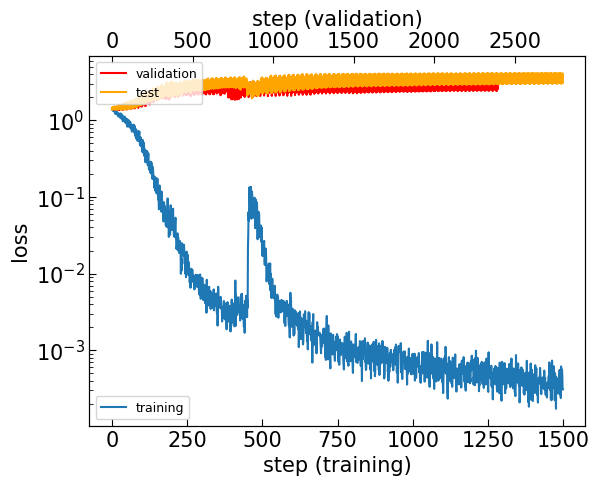

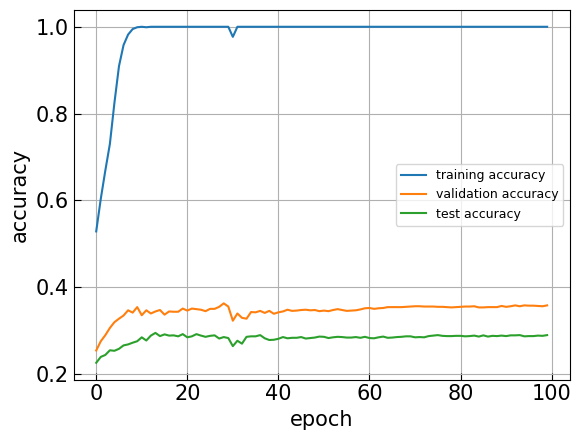

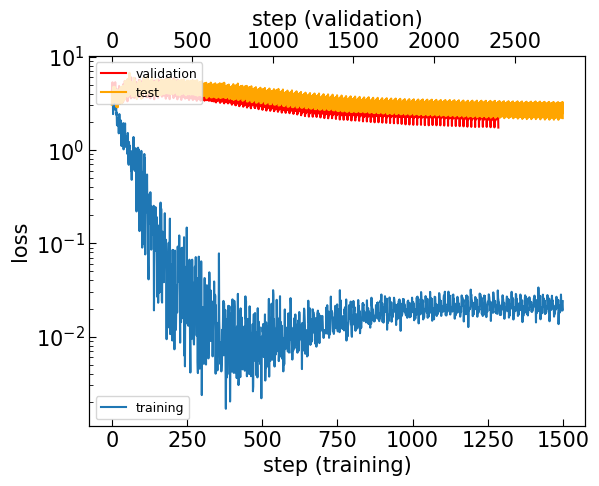

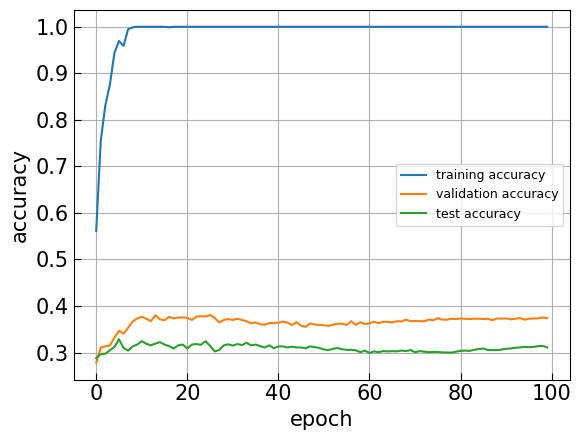

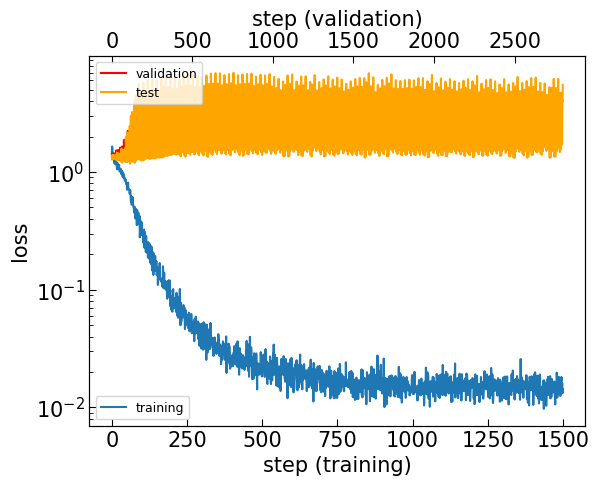

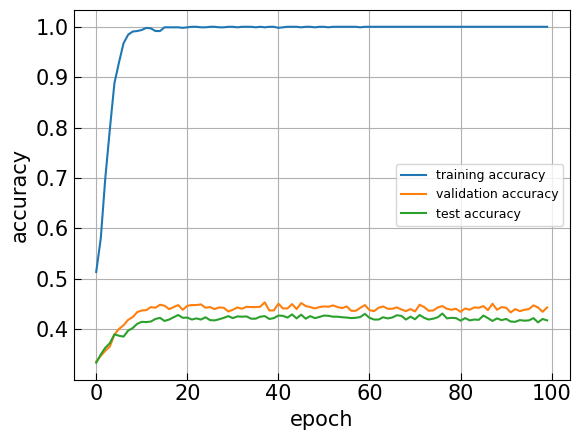

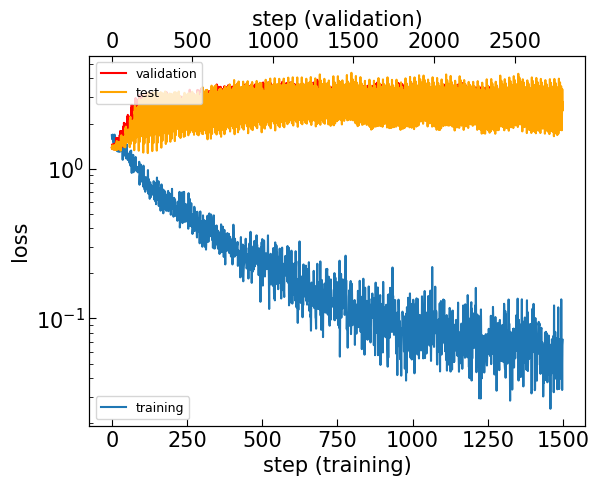

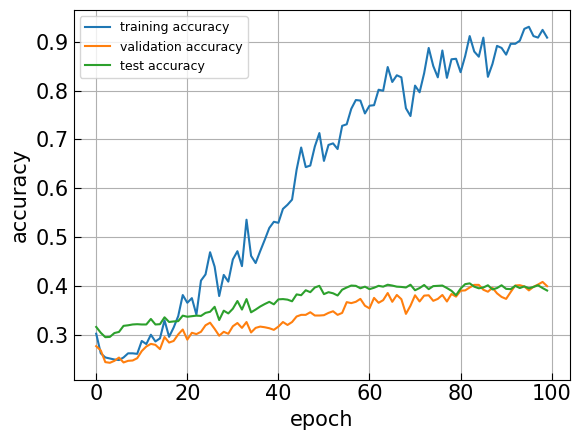

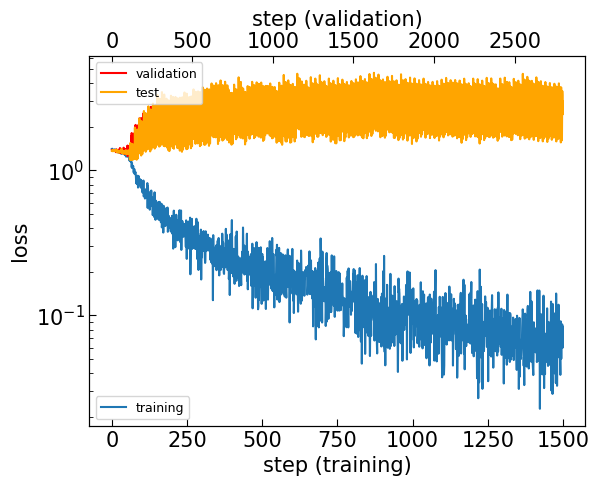

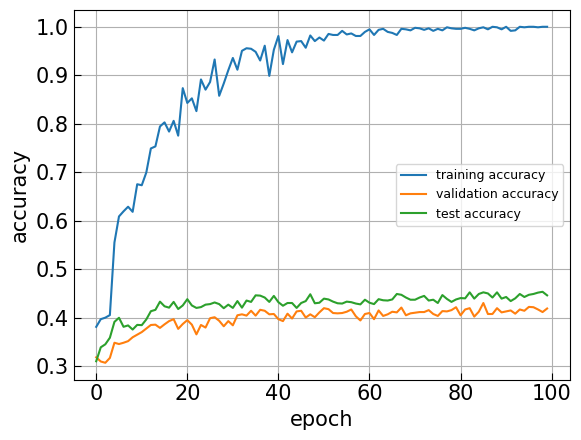

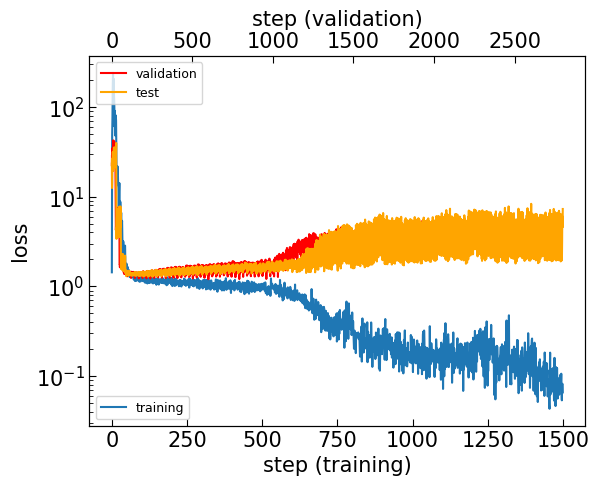

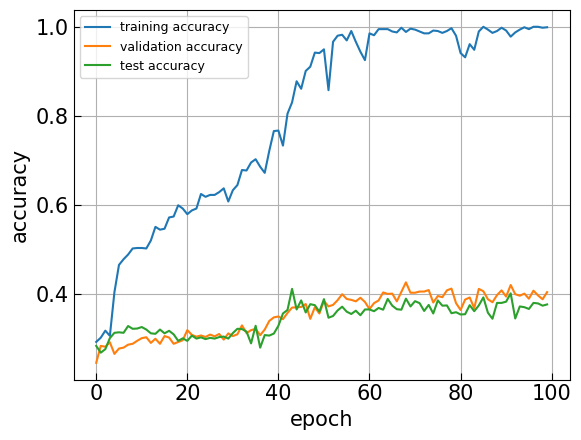

In [31]:
for model in models_name:
    print("=" * 30)
    print(models[model])
    print(num_epochs_dict[model])
    print(optimizers_dict[model])
    print(use_scheduler_dict[model])
    model_train(
        model=models[model],
        train_data=person_s0_train_dataloader,
        num_epochs=num_epochs_dict[model],
        optimizer=optimizers_dict[model],
        use_scheduler=use_scheduler_dict[model],
    )

### Performance of training on different time periods of data using CNNPlus

In [32]:
class CNNPlus(nn.Module):
    def __init__(self):
        super(CNNPlus, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(16, 32, kernel_size=(22, 1), padding=(0, 2), bias=True),
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.4),
            nn.Conv2d(
                32, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0),
            nn.Dropout(p=0.8),
            nn.Conv2d(128, 256, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), padding=0),
            nn.Dropout(p=0.4),
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=768, out_features=384, bias=True),
            nn.Linear(384, 192),
            nn.Linear(192, 4),
        )

    def forward(self, x):
        # batch size, in_channel, height, weight
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.classify(x)
        return x

time_bin=100
Shape of X after trimming: (1740, 22, 100)
Shape of X after maxpooling: (1740, 22, 50)
Shape of X after averaging+noise and concatenating: (3480, 22, 50)
Shape of X after subsampling and concatenating: (6960, 22, 50)
Shape of X after trimming: (375, 22, 100)
Shape of X after maxpooling: (375, 22, 50)
Shape of X after averaging+noise and concatenating: (750, 22, 50)
Shape of X after subsampling and concatenating: (1500, 22, 50)
Shape of X after trimming: (443, 22, 100)
Shape of X after maxpooling: (443, 22, 50)
Shape of X after averaging+noise and concatenating: (886, 22, 50)
Shape of X after subsampling and concatenating: (1772, 22, 50)
Shape of X after trimming: (236, 22, 100)
Shape of X after maxpooling: (236, 22, 50)
Shape of X after averaging+noise and concatenating: (472, 22, 50)
Shape of X after subsampling and concatenating: (944, 22, 50)
Shape of X after trimming: (50, 22, 100)
Shape of X after maxpooling: (50, 22, 50)
Shape of X after averaging+noise and concatena

100%|██████████| 100/100 [02:05<00:00,  1.26s/it, max_test_acc=0.56, max_person_s0_acc=0.57


max_person_s0_acc=0.575
max_test_acc=0.5598194130925508
max_person_s0_acc = 0.6
max_person_s1_acc = 0.56
max_person_s2_acc = 0.58
max_person_s3_acc = 0.64
max_person_s4_acc = 0.6808510638297872
max_person_s5_acc = 0.5918367346938775
max_person_s6_acc = 0.76
max_person_s7_acc = 0.72
max_person_s8_acc = 0.5106382978723404


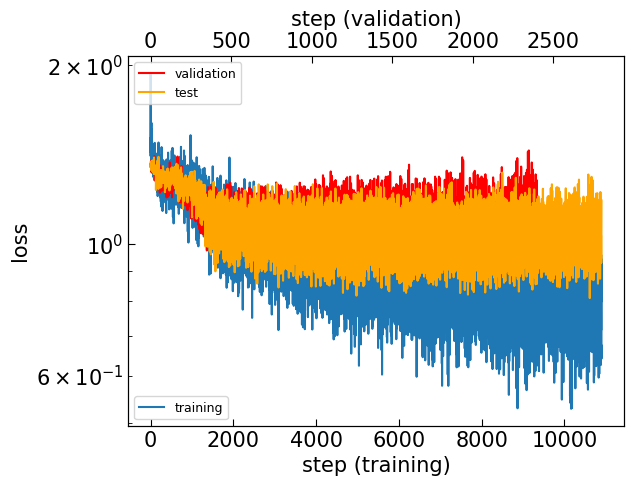

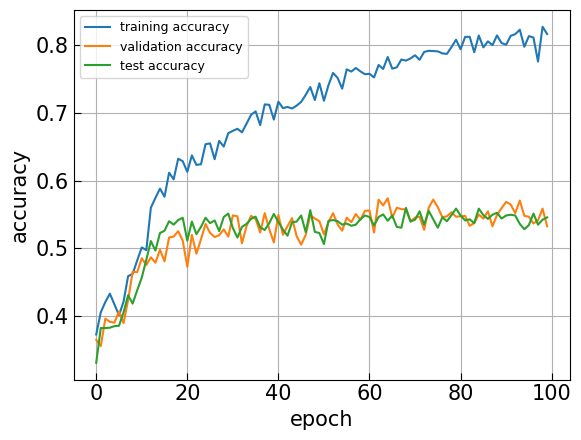

In [33]:
# for time_bin in list(range(100, 1100, 100)):
time_bin = 100
print(f"{time_bin=}")
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


s0_indices = [i for i, s in enumerate(person_train_valid) if s == 1]
X_train_valid_s0, y_train_valid_s0 = (
    X_train_valid[s0_indices],
    y_train_valid[s0_indices],
)
s0_test_indices = [i for i, s in enumerate(person_test) if s == 1]
X_test_s0, y_test_s0 = X_test[s0_test_indices], y_test[s0_test_indices]

X_test_person = []
y_test_person = []

## Preprocessing the dataset
X_train, y_train = data_prep(X_train, y_train, 2, 2, True, time_step=time_bin)
X_valid, y_valid = data_prep(X_valid, y_valid, 2, 2, True, time_step=time_bin)
X_test_prep, y_test_prep = data_prep(X_test, y_test, 2, 2, True, time_step=time_bin)
X_train_valid_s0, y_train_valid_s0 = data_prep(
    X_train_valid_s0, y_train_valid_s0, 2, 2, True, time_step=time_bin
)
X_test_s0, y_test_s0 = data_prep(X_test_s0, y_test_s0, 2, 2, True, time_step=time_bin)

for subject_id in range(9):
    s_test_indices = [i for i, s in enumerate(person_test) if s == subject_id]
    X_test_s, y_test_s = X_test_prep[s_test_indices], y_test_prep[s_test_indices]
    X_test_person.append(X_test_s)
    y_test_person.append(y_test_s)

print("Shape of testing set:", X_test_prep.shape)
print("Shape of testing labels:", y_test_prep.shape)

print("Shape of training set:", X_train.shape)
print("Shape of validation set:", X_valid.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation labels:", y_valid.shape)

print("Shape of s0 training set:", X_train_valid_s0.shape)
print("Shape of s0 training labels:", y_train_valid_s0.shape)

X_train = torch.FloatTensor(X_train).to(device)
X_valid = torch.FloatTensor(X_valid).to(device)
X_test_prep = torch.FloatTensor(X_test_prep).to(device)
X_train_valid_s0 = torch.FloatTensor(X_train_valid_s0).to(device)
X_test_s0 = torch.FloatTensor(X_test_s0).to(device)

y_train = torch.LongTensor(y_train).to(device)
y_valid = torch.LongTensor(y_valid).to(device)
y_test_prep = torch.LongTensor(y_test_prep).to(device)
y_train_valid_s0 = torch.LongTensor(y_train_valid_s0).to(device)
y_test_s0 = torch.LongTensor(y_test_s0).to(device)

for subject_id in range(9):
    X_test_person[subject_id] = torch.FloatTensor(X_test_person[subject_id]).to(device)
    y_test_person[subject_id] = torch.LongTensor(y_test_person[subject_id]).to(device)

batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_valid, y_valid)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test_prep, y_test_prep)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

person_s0_train_dataset = MyDataset(X_train_valid_s0, y_train_valid_s0)
person_s0_train_dataloader = torch.utils.data.DataLoader(
    person_s0_train_dataset, batch_size, shuffle=False
)

person_s0_test_dataset = MyDataset(X_test_s0, y_test_s0)
person_s0_test_dataloader = torch.utils.data.DataLoader(
    person_s0_test_dataset, batch_size, shuffle=False
)


person_s_test_dataloaders = []

for subject_id in range(9):
    person_s_test_dataset = MyDataset(
        X_test_person[subject_id], y_test_person[subject_id]
    )
    person_s_test_dataloader = torch.utils.data.DataLoader(
        person_s_test_dataset, batch_size, shuffle=False
    )
    person_s_test_dataloaders.append(person_s_test_dataloader)


model = CNNPlus().to(device)
print("=" * 30)

model_train(
    model=model,
    train_data=train_dataloader,
    num_epochs=100,
    optimizer=torch.optim.Adam(model.parameters(), weight_decay=0.01, lr=1e-3),
    use_scheduler=True,
)

time_bin=200
Shape of X after trimming: (1740, 22, 200)
Shape of X after maxpooling: (1740, 22, 100)
Shape of X after averaging+noise and concatenating: (3480, 22, 100)
Shape of X after subsampling and concatenating: (6960, 22, 100)
Shape of X after trimming: (375, 22, 200)
Shape of X after maxpooling: (375, 22, 100)
Shape of X after averaging+noise and concatenating: (750, 22, 100)
Shape of X after subsampling and concatenating: (1500, 22, 100)
Shape of X after trimming: (443, 22, 200)
Shape of X after maxpooling: (443, 22, 100)
Shape of X after averaging+noise and concatenating: (886, 22, 100)
Shape of X after subsampling and concatenating: (1772, 22, 100)
Shape of X after trimming: (236, 22, 200)
Shape of X after maxpooling: (236, 22, 100)
Shape of X after averaging+noise and concatenating: (472, 22, 100)
Shape of X after subsampling and concatenating: (944, 22, 100)
Shape of X after trimming: (50, 22, 200)
Shape of X after maxpooling: (50, 22, 100)
Shape of X after averaging+noise 

100%|██████████| 100/100 [02:30<00:00,  1.50s/it, max_test_acc=0.673, max_person_s0_acc=0.5


max_person_s0_acc=0.595
max_test_acc=0.672686230248307
max_person_s0_acc = 0.68
max_person_s1_acc = 0.66
max_person_s2_acc = 0.66
max_person_s3_acc = 0.72
max_person_s4_acc = 0.851063829787234
max_person_s5_acc = 0.7755102040816326
max_person_s6_acc = 0.74
max_person_s7_acc = 0.8
max_person_s8_acc = 0.723404255319149


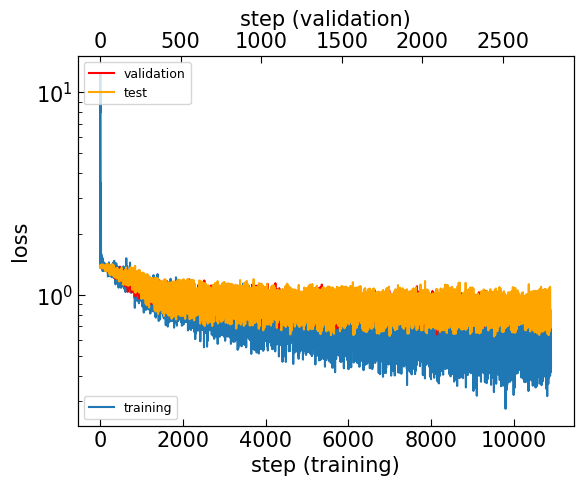

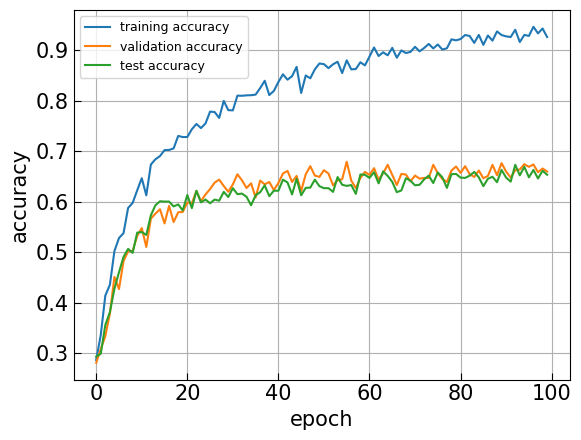

In [34]:
class CNNPlus(nn.Module):
    def __init__(self):
        super(CNNPlus, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(16, 32, kernel_size=(22, 1), padding=(0, 2), bias=True),
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.4),
            nn.Conv2d(
                32, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0),
            nn.Dropout(p=0.8),
            nn.Conv2d(128, 256, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), padding=0),
            nn.Dropout(p=0.4),
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=2560, out_features=1280, bias=True),
            nn.Linear(1280, 640),
            nn.Linear(640, 4),
        )

    def forward(self, x):
        # batch size, in_channel, height, weight
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        #         print(x.shape)
        x = self.classify(x)
        return x


# for time_bin in list(range(100, 1100, 100)):
time_bin = 200
print(f"{time_bin=}")
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


s0_indices = [i for i, s in enumerate(person_train_valid) if s == 1]
X_train_valid_s0, y_train_valid_s0 = (
    X_train_valid[s0_indices],
    y_train_valid[s0_indices],
)
s0_test_indices = [i for i, s in enumerate(person_test) if s == 1]
X_test_s0, y_test_s0 = X_test[s0_test_indices], y_test[s0_test_indices]

X_test_person = []
y_test_person = []

## Preprocessing the dataset
X_train, y_train = data_prep(X_train, y_train, 2, 2, True, time_step=time_bin)
X_valid, y_valid = data_prep(X_valid, y_valid, 2, 2, True, time_step=time_bin)
X_test_prep, y_test_prep = data_prep(X_test, y_test, 2, 2, True, time_step=time_bin)
X_train_valid_s0, y_train_valid_s0 = data_prep(
    X_train_valid_s0, y_train_valid_s0, 2, 2, True, time_step=time_bin
)
X_test_s0, y_test_s0 = data_prep(X_test_s0, y_test_s0, 2, 2, True, time_step=time_bin)

for subject_id in range(9):
    s_test_indices = [i for i, s in enumerate(person_test) if s == subject_id]
    X_test_s, y_test_s = X_test_prep[s_test_indices], y_test_prep[s_test_indices]
    X_test_person.append(X_test_s)
    y_test_person.append(y_test_s)

print("Shape of testing set:", X_test_prep.shape)
print("Shape of testing labels:", y_test_prep.shape)

print("Shape of training set:", X_train.shape)
print("Shape of validation set:", X_valid.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation labels:", y_valid.shape)

print("Shape of s0 training set:", X_train_valid_s0.shape)
print("Shape of s0 training labels:", y_train_valid_s0.shape)

X_train = torch.FloatTensor(X_train).to(device)
X_valid = torch.FloatTensor(X_valid).to(device)
X_test_prep = torch.FloatTensor(X_test_prep).to(device)
X_train_valid_s0 = torch.FloatTensor(X_train_valid_s0).to(device)
X_test_s0 = torch.FloatTensor(X_test_s0).to(device)

y_train = torch.LongTensor(y_train).to(device)
y_valid = torch.LongTensor(y_valid).to(device)
y_test_prep = torch.LongTensor(y_test_prep).to(device)
y_train_valid_s0 = torch.LongTensor(y_train_valid_s0).to(device)
y_test_s0 = torch.LongTensor(y_test_s0).to(device)

for subject_id in range(9):
    X_test_person[subject_id] = torch.FloatTensor(X_test_person[subject_id]).to(device)
    y_test_person[subject_id] = torch.LongTensor(y_test_person[subject_id]).to(device)

batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_valid, y_valid)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test_prep, y_test_prep)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

person_s0_train_dataset = MyDataset(X_train_valid_s0, y_train_valid_s0)
person_s0_train_dataloader = torch.utils.data.DataLoader(
    person_s0_train_dataset, batch_size, shuffle=False
)

person_s0_test_dataset = MyDataset(X_test_s0, y_test_s0)
person_s0_test_dataloader = torch.utils.data.DataLoader(
    person_s0_test_dataset, batch_size, shuffle=False
)


person_s_test_dataloaders = []

for subject_id in range(9):
    person_s_test_dataset = MyDataset(
        X_test_person[subject_id], y_test_person[subject_id]
    )
    person_s_test_dataloader = torch.utils.data.DataLoader(
        person_s_test_dataset, batch_size, shuffle=False
    )
    person_s_test_dataloaders.append(person_s_test_dataloader)


model = CNNPlus().to(device)
print("=" * 30)

model_train(
    model=model,
    train_data=train_dataloader,
    num_epochs=100,
    optimizer=torch.optim.Adam(model.parameters(), weight_decay=0.01, lr=1e-3),
    use_scheduler=True,
)

time_bin=300
Shape of X after trimming: (1740, 22, 300)
Shape of X after maxpooling: (1740, 22, 150)
Shape of X after averaging+noise and concatenating: (3480, 22, 150)
Shape of X after subsampling and concatenating: (6960, 22, 150)
Shape of X after trimming: (375, 22, 300)
Shape of X after maxpooling: (375, 22, 150)
Shape of X after averaging+noise and concatenating: (750, 22, 150)
Shape of X after subsampling and concatenating: (1500, 22, 150)
Shape of X after trimming: (443, 22, 300)
Shape of X after maxpooling: (443, 22, 150)
Shape of X after averaging+noise and concatenating: (886, 22, 150)
Shape of X after subsampling and concatenating: (1772, 22, 150)
Shape of X after trimming: (236, 22, 300)
Shape of X after maxpooling: (236, 22, 150)
Shape of X after averaging+noise and concatenating: (472, 22, 150)
Shape of X after subsampling and concatenating: (944, 22, 150)
Shape of X after trimming: (50, 22, 300)
Shape of X after maxpooling: (50, 22, 150)
Shape of X after averaging+noise 

100%|██████████| 100/100 [03:14<00:00,  1.95s/it, max_test_acc=0.719, max_person_s0_acc=0.6


max_person_s0_acc=0.685
max_test_acc=0.718961625282167
max_person_s0_acc = 0.72
max_person_s1_acc = 0.68
max_person_s2_acc = 0.8
max_person_s3_acc = 0.72
max_person_s4_acc = 0.8085106382978723
max_person_s5_acc = 0.8367346938775511
max_person_s6_acc = 0.78
max_person_s7_acc = 0.8
max_person_s8_acc = 0.8297872340425532


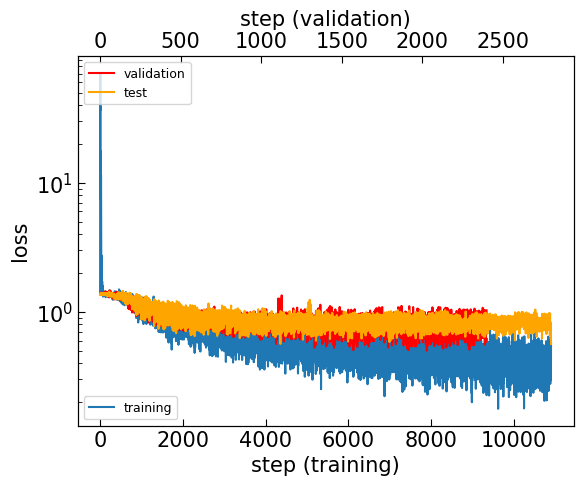

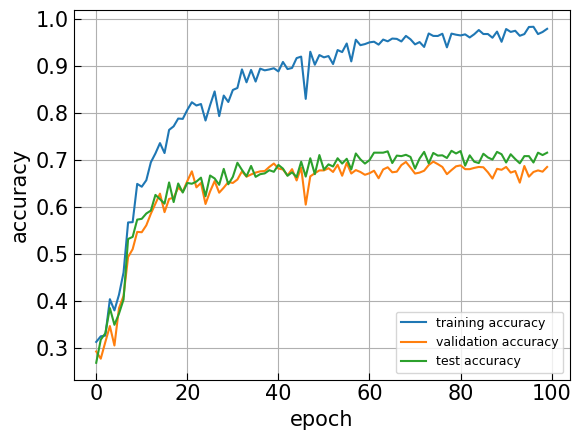

In [35]:
class CNNPlus(nn.Module):
    def __init__(self):
        super(CNNPlus, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(16, 32, kernel_size=(22, 1), padding=(0, 2), bias=True),
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.4),
            nn.Conv2d(
                32, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0),
            nn.Dropout(p=0.8),
            nn.Conv2d(128, 256, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), padding=0),
            nn.Dropout(p=0.4),
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=4096, out_features=2048, bias=True),
            nn.Linear(2048, 1024),
            nn.Linear(1024, 4),
        )

    def forward(self, x):
        # batch size, in_channel, height, weight
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        #         print(x.shape)
        x = self.classify(x)
        return x


# for time_bin in list(range(100, 1100, 100)):
time_bin = 300
print(f"{time_bin=}")
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


s0_indices = [i for i, s in enumerate(person_train_valid) if s == 1]
X_train_valid_s0, y_train_valid_s0 = (
    X_train_valid[s0_indices],
    y_train_valid[s0_indices],
)
s0_test_indices = [i for i, s in enumerate(person_test) if s == 1]
X_test_s0, y_test_s0 = X_test[s0_test_indices], y_test[s0_test_indices]

X_test_person = []
y_test_person = []

## Preprocessing the dataset
X_train, y_train = data_prep(X_train, y_train, 2, 2, True, time_step=time_bin)
X_valid, y_valid = data_prep(X_valid, y_valid, 2, 2, True, time_step=time_bin)
X_test_prep, y_test_prep = data_prep(X_test, y_test, 2, 2, True, time_step=time_bin)
X_train_valid_s0, y_train_valid_s0 = data_prep(
    X_train_valid_s0, y_train_valid_s0, 2, 2, True, time_step=time_bin
)
X_test_s0, y_test_s0 = data_prep(X_test_s0, y_test_s0, 2, 2, True, time_step=time_bin)

for subject_id in range(9):
    s_test_indices = [i for i, s in enumerate(person_test) if s == subject_id]
    X_test_s, y_test_s = X_test_prep[s_test_indices], y_test_prep[s_test_indices]
    X_test_person.append(X_test_s)
    y_test_person.append(y_test_s)

print("Shape of testing set:", X_test_prep.shape)
print("Shape of testing labels:", y_test_prep.shape)

print("Shape of training set:", X_train.shape)
print("Shape of validation set:", X_valid.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation labels:", y_valid.shape)

print("Shape of s0 training set:", X_train_valid_s0.shape)
print("Shape of s0 training labels:", y_train_valid_s0.shape)

X_train = torch.FloatTensor(X_train).to(device)
X_valid = torch.FloatTensor(X_valid).to(device)
X_test_prep = torch.FloatTensor(X_test_prep).to(device)
X_train_valid_s0 = torch.FloatTensor(X_train_valid_s0).to(device)
X_test_s0 = torch.FloatTensor(X_test_s0).to(device)

y_train = torch.LongTensor(y_train).to(device)
y_valid = torch.LongTensor(y_valid).to(device)
y_test_prep = torch.LongTensor(y_test_prep).to(device)
y_train_valid_s0 = torch.LongTensor(y_train_valid_s0).to(device)
y_test_s0 = torch.LongTensor(y_test_s0).to(device)

for subject_id in range(9):
    X_test_person[subject_id] = torch.FloatTensor(X_test_person[subject_id]).to(device)
    y_test_person[subject_id] = torch.LongTensor(y_test_person[subject_id]).to(device)

batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_valid, y_valid)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test_prep, y_test_prep)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

person_s0_train_dataset = MyDataset(X_train_valid_s0, y_train_valid_s0)
person_s0_train_dataloader = torch.utils.data.DataLoader(
    person_s0_train_dataset, batch_size, shuffle=False
)

person_s0_test_dataset = MyDataset(X_test_s0, y_test_s0)
person_s0_test_dataloader = torch.utils.data.DataLoader(
    person_s0_test_dataset, batch_size, shuffle=False
)


person_s_test_dataloaders = []

for subject_id in range(9):
    person_s_test_dataset = MyDataset(
        X_test_person[subject_id], y_test_person[subject_id]
    )
    person_s_test_dataloader = torch.utils.data.DataLoader(
        person_s_test_dataset, batch_size, shuffle=False
    )
    person_s_test_dataloaders.append(person_s_test_dataloader)


model = CNNPlus().to(device)
print("=" * 30)

model_train(
    model=model,
    train_data=train_dataloader,
    num_epochs=100,
    optimizer=torch.optim.Adam(model.parameters(), weight_decay=0.01, lr=1e-3),
    use_scheduler=True,
)

time_bin=400
Shape of X after trimming: (1740, 22, 400)
Shape of X after maxpooling: (1740, 22, 200)
Shape of X after averaging+noise and concatenating: (3480, 22, 200)
Shape of X after subsampling and concatenating: (6960, 22, 200)
Shape of X after trimming: (375, 22, 400)
Shape of X after maxpooling: (375, 22, 200)
Shape of X after averaging+noise and concatenating: (750, 22, 200)
Shape of X after subsampling and concatenating: (1500, 22, 200)
Shape of X after trimming: (443, 22, 400)
Shape of X after maxpooling: (443, 22, 200)
Shape of X after averaging+noise and concatenating: (886, 22, 200)
Shape of X after subsampling and concatenating: (1772, 22, 200)
Shape of X after trimming: (236, 22, 400)
Shape of X after maxpooling: (236, 22, 200)
Shape of X after averaging+noise and concatenating: (472, 22, 200)
Shape of X after subsampling and concatenating: (944, 22, 200)
Shape of X after trimming: (50, 22, 400)
Shape of X after maxpooling: (50, 22, 200)
Shape of X after averaging+noise 

100%|██████████| 100/100 [04:23<00:00,  2.64s/it, max_test_acc=0.723, max_person_s0_acc=0.6


max_person_s0_acc=0.635
max_test_acc=0.7229119638826185
max_person_s0_acc = 0.78
max_person_s1_acc = 0.64
max_person_s2_acc = 0.78
max_person_s3_acc = 0.78
max_person_s4_acc = 0.851063829787234
max_person_s5_acc = 0.7346938775510204
max_person_s6_acc = 0.78
max_person_s7_acc = 0.76
max_person_s8_acc = 0.8085106382978723


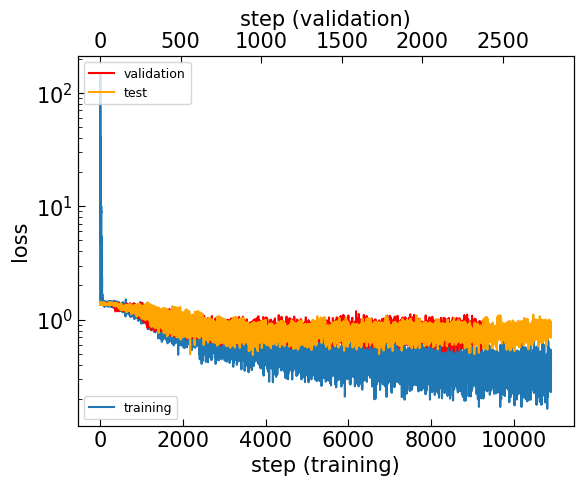

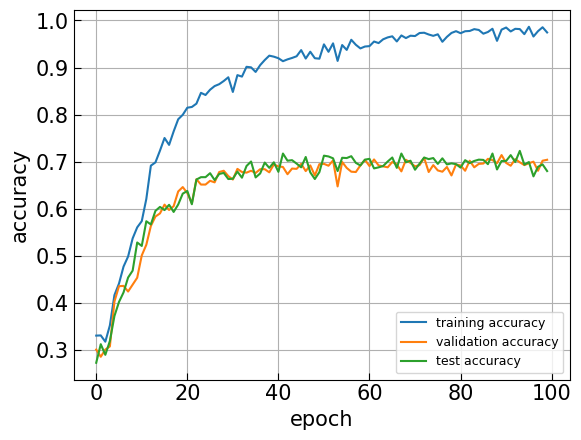

In [36]:
class CNNPlus(nn.Module):
    def __init__(self):
        super(CNNPlus, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(16, 32, kernel_size=(22, 1), padding=(0, 2), bias=True),
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.4),
            nn.Conv2d(
                32, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0),
            nn.Dropout(p=0.8),
            nn.Conv2d(128, 256, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), padding=0),
            nn.Dropout(p=0.4),
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=5632, out_features=2816, bias=True),
            nn.Linear(2816, 1408),
            nn.Linear(1408, 4),
        )

    def forward(self, x):
        # batch size, in_channel, height, weight
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        #         print(x.shape)
        x = self.classify(x)
        return x


# for time_bin in list(range(100, 1100, 100)):
time_bin = 400
print(f"{time_bin=}")
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


s0_indices = [i for i, s in enumerate(person_train_valid) if s == 1]
X_train_valid_s0, y_train_valid_s0 = (
    X_train_valid[s0_indices],
    y_train_valid[s0_indices],
)
s0_test_indices = [i for i, s in enumerate(person_test) if s == 1]
X_test_s0, y_test_s0 = X_test[s0_test_indices], y_test[s0_test_indices]

X_test_person = []
y_test_person = []

## Preprocessing the dataset
X_train, y_train = data_prep(X_train, y_train, 2, 2, True, time_step=time_bin)
X_valid, y_valid = data_prep(X_valid, y_valid, 2, 2, True, time_step=time_bin)
X_test_prep, y_test_prep = data_prep(X_test, y_test, 2, 2, True, time_step=time_bin)
X_train_valid_s0, y_train_valid_s0 = data_prep(
    X_train_valid_s0, y_train_valid_s0, 2, 2, True, time_step=time_bin
)
X_test_s0, y_test_s0 = data_prep(X_test_s0, y_test_s0, 2, 2, True, time_step=time_bin)

for subject_id in range(9):
    s_test_indices = [i for i, s in enumerate(person_test) if s == subject_id]
    X_test_s, y_test_s = X_test_prep[s_test_indices], y_test_prep[s_test_indices]
    X_test_person.append(X_test_s)
    y_test_person.append(y_test_s)

print("Shape of testing set:", X_test_prep.shape)
print("Shape of testing labels:", y_test_prep.shape)

print("Shape of training set:", X_train.shape)
print("Shape of validation set:", X_valid.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation labels:", y_valid.shape)

print("Shape of s0 training set:", X_train_valid_s0.shape)
print("Shape of s0 training labels:", y_train_valid_s0.shape)

X_train = torch.FloatTensor(X_train).to(device)
X_valid = torch.FloatTensor(X_valid).to(device)
X_test_prep = torch.FloatTensor(X_test_prep).to(device)
X_train_valid_s0 = torch.FloatTensor(X_train_valid_s0).to(device)
X_test_s0 = torch.FloatTensor(X_test_s0).to(device)

y_train = torch.LongTensor(y_train).to(device)
y_valid = torch.LongTensor(y_valid).to(device)
y_test_prep = torch.LongTensor(y_test_prep).to(device)
y_train_valid_s0 = torch.LongTensor(y_train_valid_s0).to(device)
y_test_s0 = torch.LongTensor(y_test_s0).to(device)

for subject_id in range(9):
    X_test_person[subject_id] = torch.FloatTensor(X_test_person[subject_id]).to(device)
    y_test_person[subject_id] = torch.LongTensor(y_test_person[subject_id]).to(device)

batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_valid, y_valid)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test_prep, y_test_prep)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

person_s0_train_dataset = MyDataset(X_train_valid_s0, y_train_valid_s0)
person_s0_train_dataloader = torch.utils.data.DataLoader(
    person_s0_train_dataset, batch_size, shuffle=False
)

person_s0_test_dataset = MyDataset(X_test_s0, y_test_s0)
person_s0_test_dataloader = torch.utils.data.DataLoader(
    person_s0_test_dataset, batch_size, shuffle=False
)


person_s_test_dataloaders = []

for subject_id in range(9):
    person_s_test_dataset = MyDataset(
        X_test_person[subject_id], y_test_person[subject_id]
    )
    person_s_test_dataloader = torch.utils.data.DataLoader(
        person_s_test_dataset, batch_size, shuffle=False
    )
    person_s_test_dataloaders.append(person_s_test_dataloader)


model = CNNPlus().to(device)
print("=" * 30)

model_train(
    model=model,
    train_data=train_dataloader,
    num_epochs=100,
    optimizer=torch.optim.Adam(model.parameters(), weight_decay=0.01, lr=1e-3),
    use_scheduler=True,
)

time_bin=500
Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of X after trimming: (236, 22, 500)
Shape of X after maxpooling: (236, 22, 250)
Shape of X after averaging+noise and concatenating: (472, 22, 250)
Shape of X after subsampling and concatenating: (944, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise 

100%|██████████| 100/100 [05:46<00:00,  3.47s/it, max_test_acc=0.725, max_person_s0_acc=0.6


max_person_s0_acc=0.69
max_test_acc=0.7251693002257337
max_person_s0_acc = 0.76
max_person_s1_acc = 0.74
max_person_s2_acc = 0.82
max_person_s3_acc = 0.84
max_person_s4_acc = 0.8723404255319149
max_person_s5_acc = 0.7346938775510204
max_person_s6_acc = 0.8
max_person_s7_acc = 0.78
max_person_s8_acc = 0.8085106382978723


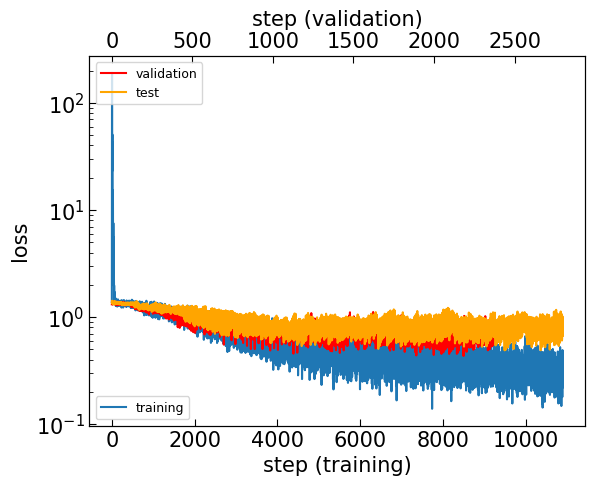

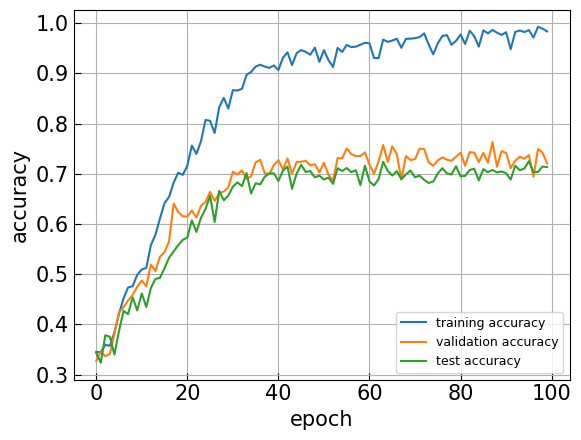

In [37]:
class CNNPlus(nn.Module):
    def __init__(self):
        super(CNNPlus, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(16, 32, kernel_size=(22, 1), padding=(0, 2), bias=True),
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.4),
            nn.Conv2d(
                32, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0),
            nn.Dropout(p=0.8),
            nn.Conv2d(128, 256, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), padding=0),
            nn.Dropout(p=0.4),
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=7168, out_features=3584, bias=True),
            nn.Linear(3584, 1792),
            nn.Linear(1792, 4),
        )

    def forward(self, x):
        # batch size, in_channel, height, weight
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        #         print(x.shape)
        x = self.classify(x)
        return x


# for time_bin in list(range(100, 1100, 100)):
time_bin = 500
print(f"{time_bin=}")
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


s0_indices = [i for i, s in enumerate(person_train_valid) if s == 1]
X_train_valid_s0, y_train_valid_s0 = (
    X_train_valid[s0_indices],
    y_train_valid[s0_indices],
)
s0_test_indices = [i for i, s in enumerate(person_test) if s == 1]
X_test_s0, y_test_s0 = X_test[s0_test_indices], y_test[s0_test_indices]

X_test_person = []
y_test_person = []

## Preprocessing the dataset
X_train, y_train = data_prep(X_train, y_train, 2, 2, True, time_step=time_bin)
X_valid, y_valid = data_prep(X_valid, y_valid, 2, 2, True, time_step=time_bin)
X_test_prep, y_test_prep = data_prep(X_test, y_test, 2, 2, True, time_step=time_bin)
X_train_valid_s0, y_train_valid_s0 = data_prep(
    X_train_valid_s0, y_train_valid_s0, 2, 2, True, time_step=time_bin
)
X_test_s0, y_test_s0 = data_prep(X_test_s0, y_test_s0, 2, 2, True, time_step=time_bin)

for subject_id in range(9):
    s_test_indices = [i for i, s in enumerate(person_test) if s == subject_id]
    X_test_s, y_test_s = X_test_prep[s_test_indices], y_test_prep[s_test_indices]
    X_test_person.append(X_test_s)
    y_test_person.append(y_test_s)

print("Shape of testing set:", X_test_prep.shape)
print("Shape of testing labels:", y_test_prep.shape)

print("Shape of training set:", X_train.shape)
print("Shape of validation set:", X_valid.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation labels:", y_valid.shape)

print("Shape of s0 training set:", X_train_valid_s0.shape)
print("Shape of s0 training labels:", y_train_valid_s0.shape)

X_train = torch.FloatTensor(X_train).to(device)
X_valid = torch.FloatTensor(X_valid).to(device)
X_test_prep = torch.FloatTensor(X_test_prep).to(device)
X_train_valid_s0 = torch.FloatTensor(X_train_valid_s0).to(device)
X_test_s0 = torch.FloatTensor(X_test_s0).to(device)

y_train = torch.LongTensor(y_train).to(device)
y_valid = torch.LongTensor(y_valid).to(device)
y_test_prep = torch.LongTensor(y_test_prep).to(device)
y_train_valid_s0 = torch.LongTensor(y_train_valid_s0).to(device)
y_test_s0 = torch.LongTensor(y_test_s0).to(device)

for subject_id in range(9):
    X_test_person[subject_id] = torch.FloatTensor(X_test_person[subject_id]).to(device)
    y_test_person[subject_id] = torch.LongTensor(y_test_person[subject_id]).to(device)

batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_valid, y_valid)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test_prep, y_test_prep)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

person_s0_train_dataset = MyDataset(X_train_valid_s0, y_train_valid_s0)
person_s0_train_dataloader = torch.utils.data.DataLoader(
    person_s0_train_dataset, batch_size, shuffle=False
)

person_s0_test_dataset = MyDataset(X_test_s0, y_test_s0)
person_s0_test_dataloader = torch.utils.data.DataLoader(
    person_s0_test_dataset, batch_size, shuffle=False
)


person_s_test_dataloaders = []

for subject_id in range(9):
    person_s_test_dataset = MyDataset(
        X_test_person[subject_id], y_test_person[subject_id]
    )
    person_s_test_dataloader = torch.utils.data.DataLoader(
        person_s_test_dataset, batch_size, shuffle=False
    )
    person_s_test_dataloaders.append(person_s_test_dataloader)


model = CNNPlus().to(device)
print("=" * 30)

model_train(
    model=model,
    train_data=train_dataloader,
    num_epochs=100,
    optimizer=torch.optim.Adam(model.parameters(), weight_decay=0.01, lr=1e-3),
    use_scheduler=True,
)

time_bin=600
Shape of X after trimming: (1740, 22, 600)
Shape of X after maxpooling: (1740, 22, 300)
Shape of X after averaging+noise and concatenating: (3480, 22, 300)
Shape of X after subsampling and concatenating: (6960, 22, 300)
Shape of X after trimming: (375, 22, 600)
Shape of X after maxpooling: (375, 22, 300)
Shape of X after averaging+noise and concatenating: (750, 22, 300)
Shape of X after subsampling and concatenating: (1500, 22, 300)
Shape of X after trimming: (443, 22, 600)
Shape of X after maxpooling: (443, 22, 300)
Shape of X after averaging+noise and concatenating: (886, 22, 300)
Shape of X after subsampling and concatenating: (1772, 22, 300)
Shape of X after trimming: (236, 22, 600)
Shape of X after maxpooling: (236, 22, 300)
Shape of X after averaging+noise and concatenating: (472, 22, 300)
Shape of X after subsampling and concatenating: (944, 22, 300)
Shape of X after trimming: (50, 22, 600)
Shape of X after maxpooling: (50, 22, 300)
Shape of X after averaging+noise 

100%|██████████| 100/100 [07:44<00:00,  4.65s/it, max_test_acc=0.739, max_person_s0_acc=0.6


max_person_s0_acc=0.635
max_test_acc=0.7392776523702032
max_person_s0_acc = 0.78
max_person_s1_acc = 0.68
max_person_s2_acc = 0.86
max_person_s3_acc = 0.86
max_person_s4_acc = 0.8723404255319149
max_person_s5_acc = 0.7551020408163265
max_person_s6_acc = 0.84
max_person_s7_acc = 0.78
max_person_s8_acc = 0.8085106382978723


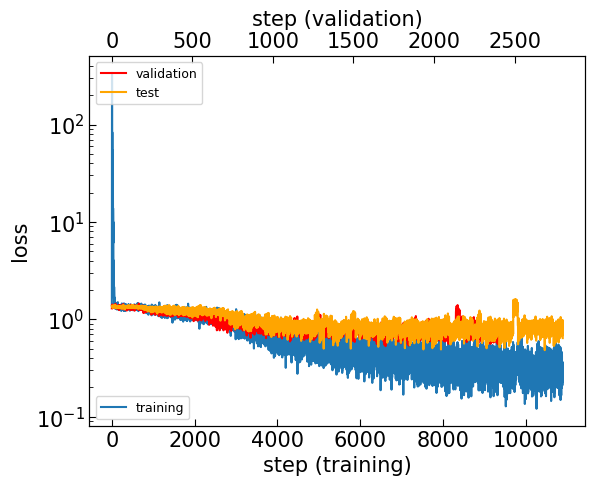

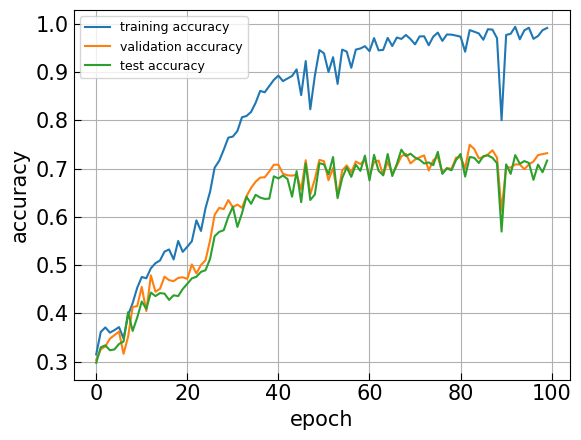

In [38]:
class CNNPlus(nn.Module):
    def __init__(self):
        super(CNNPlus, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(16, 32, kernel_size=(22, 1), padding=(0, 2), bias=True),
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.4),
            nn.Conv2d(
                32, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0),
            nn.Dropout(p=0.8),
            nn.Conv2d(128, 256, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), padding=0),
            nn.Dropout(p=0.4),
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=8960, out_features=4480, bias=True),
            nn.Linear(4480, 2240),
            nn.Linear(2240, 4),
        )

    def forward(self, x):
        # batch size, in_channel, height, weight
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        #         print(x.shape)
        x = self.classify(x)
        return x


# for time_bin in list(range(100, 1100, 100)):
time_bin = 600
print(f"{time_bin=}")
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


s0_indices = [i for i, s in enumerate(person_train_valid) if s == 1]
X_train_valid_s0, y_train_valid_s0 = (
    X_train_valid[s0_indices],
    y_train_valid[s0_indices],
)
s0_test_indices = [i for i, s in enumerate(person_test) if s == 1]
X_test_s0, y_test_s0 = X_test[s0_test_indices], y_test[s0_test_indices]

X_test_person = []
y_test_person = []

## Preprocessing the dataset
X_train, y_train = data_prep(X_train, y_train, 2, 2, True, time_step=time_bin)
X_valid, y_valid = data_prep(X_valid, y_valid, 2, 2, True, time_step=time_bin)
X_test_prep, y_test_prep = data_prep(X_test, y_test, 2, 2, True, time_step=time_bin)
X_train_valid_s0, y_train_valid_s0 = data_prep(
    X_train_valid_s0, y_train_valid_s0, 2, 2, True, time_step=time_bin
)
X_test_s0, y_test_s0 = data_prep(X_test_s0, y_test_s0, 2, 2, True, time_step=time_bin)

for subject_id in range(9):
    s_test_indices = [i for i, s in enumerate(person_test) if s == subject_id]
    X_test_s, y_test_s = X_test_prep[s_test_indices], y_test_prep[s_test_indices]
    X_test_person.append(X_test_s)
    y_test_person.append(y_test_s)

print("Shape of testing set:", X_test_prep.shape)
print("Shape of testing labels:", y_test_prep.shape)

print("Shape of training set:", X_train.shape)
print("Shape of validation set:", X_valid.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation labels:", y_valid.shape)

print("Shape of s0 training set:", X_train_valid_s0.shape)
print("Shape of s0 training labels:", y_train_valid_s0.shape)

X_train = torch.FloatTensor(X_train).to(device)
X_valid = torch.FloatTensor(X_valid).to(device)
X_test_prep = torch.FloatTensor(X_test_prep).to(device)
X_train_valid_s0 = torch.FloatTensor(X_train_valid_s0).to(device)
X_test_s0 = torch.FloatTensor(X_test_s0).to(device)

y_train = torch.LongTensor(y_train).to(device)
y_valid = torch.LongTensor(y_valid).to(device)
y_test_prep = torch.LongTensor(y_test_prep).to(device)
y_train_valid_s0 = torch.LongTensor(y_train_valid_s0).to(device)
y_test_s0 = torch.LongTensor(y_test_s0).to(device)

for subject_id in range(9):
    X_test_person[subject_id] = torch.FloatTensor(X_test_person[subject_id]).to(device)
    y_test_person[subject_id] = torch.LongTensor(y_test_person[subject_id]).to(device)

batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_valid, y_valid)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test_prep, y_test_prep)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

person_s0_train_dataset = MyDataset(X_train_valid_s0, y_train_valid_s0)
person_s0_train_dataloader = torch.utils.data.DataLoader(
    person_s0_train_dataset, batch_size, shuffle=False
)

person_s0_test_dataset = MyDataset(X_test_s0, y_test_s0)
person_s0_test_dataloader = torch.utils.data.DataLoader(
    person_s0_test_dataset, batch_size, shuffle=False
)


person_s_test_dataloaders = []

for subject_id in range(9):
    person_s_test_dataset = MyDataset(
        X_test_person[subject_id], y_test_person[subject_id]
    )
    person_s_test_dataloader = torch.utils.data.DataLoader(
        person_s_test_dataset, batch_size, shuffle=False
    )
    person_s_test_dataloaders.append(person_s_test_dataloader)


model = CNNPlus().to(device)
print("=" * 30)

model_train(
    model=model,
    train_data=train_dataloader,
    num_epochs=100,
    optimizer=torch.optim.Adam(model.parameters(), weight_decay=0.01, lr=1e-3),
    use_scheduler=True,
)

time_bin=700
Shape of X after trimming: (1740, 22, 700)
Shape of X after maxpooling: (1740, 22, 350)
Shape of X after averaging+noise and concatenating: (3480, 22, 350)
Shape of X after subsampling and concatenating: (6960, 22, 350)
Shape of X after trimming: (375, 22, 700)
Shape of X after maxpooling: (375, 22, 350)
Shape of X after averaging+noise and concatenating: (750, 22, 350)
Shape of X after subsampling and concatenating: (1500, 22, 350)
Shape of X after trimming: (443, 22, 700)
Shape of X after maxpooling: (443, 22, 350)
Shape of X after averaging+noise and concatenating: (886, 22, 350)
Shape of X after subsampling and concatenating: (1772, 22, 350)
Shape of X after trimming: (236, 22, 700)
Shape of X after maxpooling: (236, 22, 350)
Shape of X after averaging+noise and concatenating: (472, 22, 350)
Shape of X after subsampling and concatenating: (944, 22, 350)
Shape of X after trimming: (50, 22, 700)
Shape of X after maxpooling: (50, 22, 350)
Shape of X after averaging+noise 

100%|██████████| 100/100 [09:52<00:00,  5.92s/it, max_test_acc=0.699, max_person_s0_acc=0.6


max_person_s0_acc=0.61
max_test_acc=0.6992099322799097
max_person_s0_acc = 0.7
max_person_s1_acc = 0.6
max_person_s2_acc = 0.82
max_person_s3_acc = 0.7
max_person_s4_acc = 0.8085106382978723
max_person_s5_acc = 0.7142857142857143
max_person_s6_acc = 0.84
max_person_s7_acc = 0.74
max_person_s8_acc = 0.8085106382978723


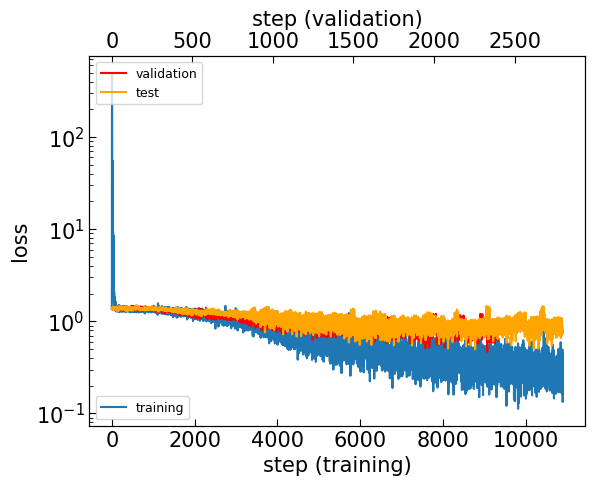

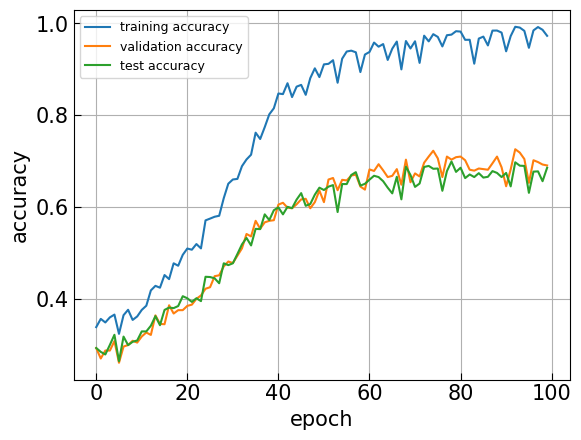

In [39]:
class CNNPlus(nn.Module):
    def __init__(self):
        super(CNNPlus, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(16, 32, kernel_size=(22, 1), padding=(0, 2), bias=True),
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.4),
            nn.Conv2d(
                32, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0),
            nn.Dropout(p=0.8),
            nn.Conv2d(128, 256, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), padding=0),
            nn.Dropout(p=0.4),
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=10496, out_features=5248, bias=True),
            nn.Linear(5248, 2624),
            nn.Linear(2624, 4),
        )

    def forward(self, x):
        # batch size, in_channel, height, weight
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        #         print(x.shape)
        x = self.classify(x)
        return x


# for time_bin in list(range(100, 1100, 100)):
time_bin = 700
print(f"{time_bin=}")
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


s0_indices = [i for i, s in enumerate(person_train_valid) if s == 1]
X_train_valid_s0, y_train_valid_s0 = (
    X_train_valid[s0_indices],
    y_train_valid[s0_indices],
)
s0_test_indices = [i for i, s in enumerate(person_test) if s == 1]
X_test_s0, y_test_s0 = X_test[s0_test_indices], y_test[s0_test_indices]

X_test_person = []
y_test_person = []

## Preprocessing the dataset
X_train, y_train = data_prep(X_train, y_train, 2, 2, True, time_step=time_bin)
X_valid, y_valid = data_prep(X_valid, y_valid, 2, 2, True, time_step=time_bin)
X_test_prep, y_test_prep = data_prep(X_test, y_test, 2, 2, True, time_step=time_bin)
X_train_valid_s0, y_train_valid_s0 = data_prep(
    X_train_valid_s0, y_train_valid_s0, 2, 2, True, time_step=time_bin
)
X_test_s0, y_test_s0 = data_prep(X_test_s0, y_test_s0, 2, 2, True, time_step=time_bin)

for subject_id in range(9):
    s_test_indices = [i for i, s in enumerate(person_test) if s == subject_id]
    X_test_s, y_test_s = X_test_prep[s_test_indices], y_test_prep[s_test_indices]
    X_test_person.append(X_test_s)
    y_test_person.append(y_test_s)

print("Shape of testing set:", X_test_prep.shape)
print("Shape of testing labels:", y_test_prep.shape)

print("Shape of training set:", X_train.shape)
print("Shape of validation set:", X_valid.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation labels:", y_valid.shape)

print("Shape of s0 training set:", X_train_valid_s0.shape)
print("Shape of s0 training labels:", y_train_valid_s0.shape)

X_train = torch.FloatTensor(X_train).to(device)
X_valid = torch.FloatTensor(X_valid).to(device)
X_test_prep = torch.FloatTensor(X_test_prep).to(device)
X_train_valid_s0 = torch.FloatTensor(X_train_valid_s0).to(device)
X_test_s0 = torch.FloatTensor(X_test_s0).to(device)

y_train = torch.LongTensor(y_train).to(device)
y_valid = torch.LongTensor(y_valid).to(device)
y_test_prep = torch.LongTensor(y_test_prep).to(device)
y_train_valid_s0 = torch.LongTensor(y_train_valid_s0).to(device)
y_test_s0 = torch.LongTensor(y_test_s0).to(device)

for subject_id in range(9):
    X_test_person[subject_id] = torch.FloatTensor(X_test_person[subject_id]).to(device)
    y_test_person[subject_id] = torch.LongTensor(y_test_person[subject_id]).to(device)

batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_valid, y_valid)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test_prep, y_test_prep)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

person_s0_train_dataset = MyDataset(X_train_valid_s0, y_train_valid_s0)
person_s0_train_dataloader = torch.utils.data.DataLoader(
    person_s0_train_dataset, batch_size, shuffle=False
)

person_s0_test_dataset = MyDataset(X_test_s0, y_test_s0)
person_s0_test_dataloader = torch.utils.data.DataLoader(
    person_s0_test_dataset, batch_size, shuffle=False
)


person_s_test_dataloaders = []

for subject_id in range(9):
    person_s_test_dataset = MyDataset(
        X_test_person[subject_id], y_test_person[subject_id]
    )
    person_s_test_dataloader = torch.utils.data.DataLoader(
        person_s_test_dataset, batch_size, shuffle=False
    )
    person_s_test_dataloaders.append(person_s_test_dataloader)


model = CNNPlus().to(device)
print("=" * 30)

model_train(
    model=model,
    train_data=train_dataloader,
    num_epochs=100,
    optimizer=torch.optim.Adam(model.parameters(), weight_decay=0.01, lr=1e-3),
    use_scheduler=True,
)

time_bin=800
Shape of X after trimming: (1740, 22, 800)
Shape of X after maxpooling: (1740, 22, 400)
Shape of X after averaging+noise and concatenating: (3480, 22, 400)
Shape of X after subsampling and concatenating: (6960, 22, 400)
Shape of X after trimming: (375, 22, 800)
Shape of X after maxpooling: (375, 22, 400)
Shape of X after averaging+noise and concatenating: (750, 22, 400)
Shape of X after subsampling and concatenating: (1500, 22, 400)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after averaging+noise and concatenating: (886, 22, 400)
Shape of X after subsampling and concatenating: (1772, 22, 400)
Shape of X after trimming: (236, 22, 800)
Shape of X after maxpooling: (236, 22, 400)
Shape of X after averaging+noise and concatenating: (472, 22, 400)
Shape of X after subsampling and concatenating: (944, 22, 400)
Shape of X after trimming: (50, 22, 800)
Shape of X after maxpooling: (50, 22, 400)
Shape of X after averaging+noise 

100%|██████████| 100/100 [12:05<00:00,  7.26s/it, max_test_acc=0.698, max_person_s0_acc=0.6


max_person_s0_acc=0.605
max_test_acc=0.6975169300225733
max_person_s0_acc = 0.68
max_person_s1_acc = 0.64
max_person_s2_acc = 0.8
max_person_s3_acc = 0.74
max_person_s4_acc = 0.7872340425531915
max_person_s5_acc = 0.7551020408163265
max_person_s6_acc = 0.78
max_person_s7_acc = 0.74
max_person_s8_acc = 0.723404255319149


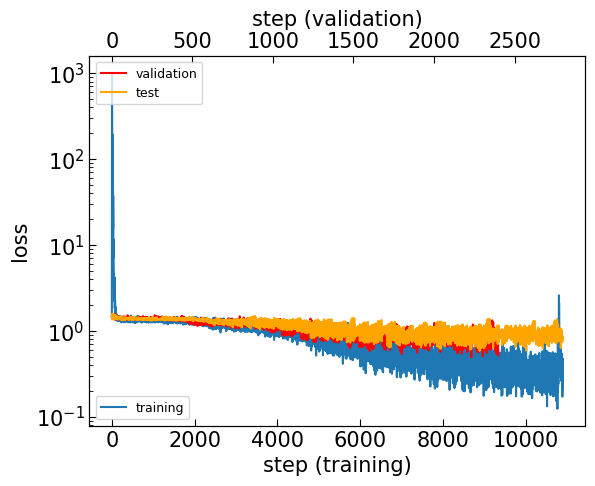

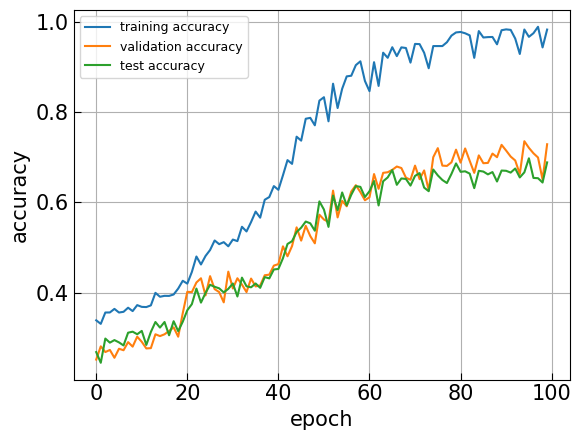

In [40]:
class CNNPlus(nn.Module):
    def __init__(self):
        super(CNNPlus, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(16, 32, kernel_size=(22, 1), padding=(0, 2), bias=True),
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.4),
            nn.Conv2d(
                32, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0),
            nn.Dropout(p=0.8),
            nn.Conv2d(128, 256, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), padding=0),
            nn.Dropout(p=0.4),
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=12032, out_features=6016, bias=True),
            nn.Linear(6016, 3008),
            nn.Linear(3008, 4),
        )

    def forward(self, x):
        # batch size, in_channel, height, weight
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        #         print(x.shape)
        x = self.classify(x)
        return x


# for time_bin in list(range(100, 1100, 100)):
time_bin = 800
print(f"{time_bin=}")
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


s0_indices = [i for i, s in enumerate(person_train_valid) if s == 1]
X_train_valid_s0, y_train_valid_s0 = (
    X_train_valid[s0_indices],
    y_train_valid[s0_indices],
)
s0_test_indices = [i for i, s in enumerate(person_test) if s == 1]
X_test_s0, y_test_s0 = X_test[s0_test_indices], y_test[s0_test_indices]

X_test_person = []
y_test_person = []

## Preprocessing the dataset
X_train, y_train = data_prep(X_train, y_train, 2, 2, True, time_step=time_bin)
X_valid, y_valid = data_prep(X_valid, y_valid, 2, 2, True, time_step=time_bin)
X_test_prep, y_test_prep = data_prep(X_test, y_test, 2, 2, True, time_step=time_bin)
X_train_valid_s0, y_train_valid_s0 = data_prep(
    X_train_valid_s0, y_train_valid_s0, 2, 2, True, time_step=time_bin
)
X_test_s0, y_test_s0 = data_prep(X_test_s0, y_test_s0, 2, 2, True, time_step=time_bin)

for subject_id in range(9):
    s_test_indices = [i for i, s in enumerate(person_test) if s == subject_id]
    X_test_s, y_test_s = X_test_prep[s_test_indices], y_test_prep[s_test_indices]
    X_test_person.append(X_test_s)
    y_test_person.append(y_test_s)

print("Shape of testing set:", X_test_prep.shape)
print("Shape of testing labels:", y_test_prep.shape)

print("Shape of training set:", X_train.shape)
print("Shape of validation set:", X_valid.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation labels:", y_valid.shape)

print("Shape of s0 training set:", X_train_valid_s0.shape)
print("Shape of s0 training labels:", y_train_valid_s0.shape)

X_train = torch.FloatTensor(X_train).to(device)
X_valid = torch.FloatTensor(X_valid).to(device)
X_test_prep = torch.FloatTensor(X_test_prep).to(device)
X_train_valid_s0 = torch.FloatTensor(X_train_valid_s0).to(device)
X_test_s0 = torch.FloatTensor(X_test_s0).to(device)

y_train = torch.LongTensor(y_train).to(device)
y_valid = torch.LongTensor(y_valid).to(device)
y_test_prep = torch.LongTensor(y_test_prep).to(device)
y_train_valid_s0 = torch.LongTensor(y_train_valid_s0).to(device)
y_test_s0 = torch.LongTensor(y_test_s0).to(device)

for subject_id in range(9):
    X_test_person[subject_id] = torch.FloatTensor(X_test_person[subject_id]).to(device)
    y_test_person[subject_id] = torch.LongTensor(y_test_person[subject_id]).to(device)

batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_valid, y_valid)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test_prep, y_test_prep)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

person_s0_train_dataset = MyDataset(X_train_valid_s0, y_train_valid_s0)
person_s0_train_dataloader = torch.utils.data.DataLoader(
    person_s0_train_dataset, batch_size, shuffle=False
)

person_s0_test_dataset = MyDataset(X_test_s0, y_test_s0)
person_s0_test_dataloader = torch.utils.data.DataLoader(
    person_s0_test_dataset, batch_size, shuffle=False
)


person_s_test_dataloaders = []

for subject_id in range(9):
    person_s_test_dataset = MyDataset(
        X_test_person[subject_id], y_test_person[subject_id]
    )
    person_s_test_dataloader = torch.utils.data.DataLoader(
        person_s_test_dataset, batch_size, shuffle=False
    )
    person_s_test_dataloaders.append(person_s_test_dataloader)


model = CNNPlus().to(device)
print("=" * 30)

model_train(
    model=model,
    train_data=train_dataloader,
    num_epochs=100,
    optimizer=torch.optim.Adam(model.parameters(), weight_decay=0.01, lr=1e-3),
    use_scheduler=True,
)

time_bin=900
Shape of X after trimming: (1740, 22, 900)
Shape of X after maxpooling: (1740, 22, 450)
Shape of X after averaging+noise and concatenating: (3480, 22, 450)
Shape of X after subsampling and concatenating: (6960, 22, 450)
Shape of X after trimming: (375, 22, 900)
Shape of X after maxpooling: (375, 22, 450)
Shape of X after averaging+noise and concatenating: (750, 22, 450)
Shape of X after subsampling and concatenating: (1500, 22, 450)
Shape of X after trimming: (443, 22, 900)
Shape of X after maxpooling: (443, 22, 450)
Shape of X after averaging+noise and concatenating: (886, 22, 450)
Shape of X after subsampling and concatenating: (1772, 22, 450)
Shape of X after trimming: (236, 22, 900)
Shape of X after maxpooling: (236, 22, 450)
Shape of X after averaging+noise and concatenating: (472, 22, 450)
Shape of X after subsampling and concatenating: (944, 22, 450)
Shape of X after trimming: (50, 22, 900)
Shape of X after maxpooling: (50, 22, 450)
Shape of X after averaging+noise 

100%|██████████| 100/100 [14:37<00:00,  8.77s/it, max_test_acc=0.7, max_person_s0_acc=0.615


max_person_s0_acc=0.615
max_test_acc=0.6997742663656885
max_person_s0_acc = 0.7
max_person_s1_acc = 0.64
max_person_s2_acc = 0.84
max_person_s3_acc = 0.76
max_person_s4_acc = 0.7659574468085106
max_person_s5_acc = 0.6938775510204082
max_person_s6_acc = 0.74
max_person_s7_acc = 0.74
max_person_s8_acc = 0.7446808510638298


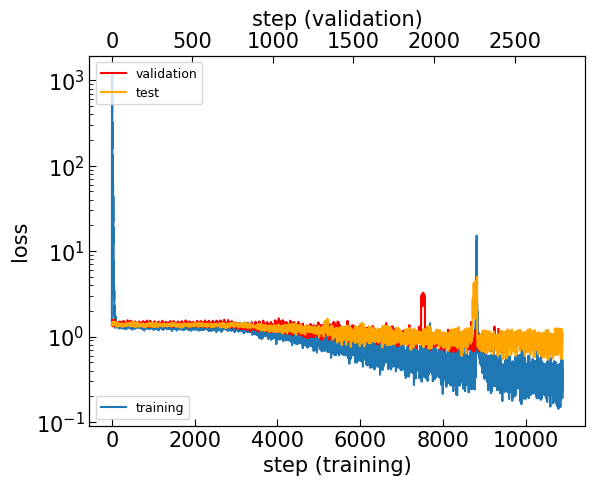

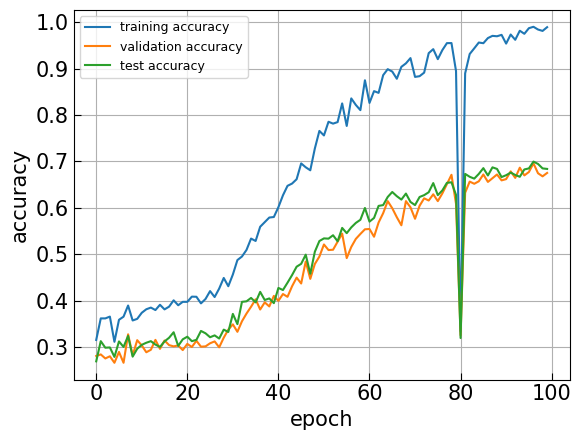

In [41]:
class CNNPlus(nn.Module):
    def __init__(self):
        super(CNNPlus, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(16, 32, kernel_size=(22, 1), padding=(0, 2), bias=True),
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.4),
            nn.Conv2d(
                32, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0),
            nn.Dropout(p=0.8),
            nn.Conv2d(128, 256, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), padding=0),
            nn.Dropout(p=0.4),
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=13568, out_features=6784, bias=True),
            nn.Linear(6784, 3392),
            nn.Linear(3392, 4),
        )

    def forward(self, x):
        # batch size, in_channel, height, weight
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        #         print(x.shape)
        x = self.classify(x)
        return x


# for time_bin in list(range(100, 1100, 100)):
time_bin = 900
print(f"{time_bin=}")
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


s0_indices = [i for i, s in enumerate(person_train_valid) if s == 1]
X_train_valid_s0, y_train_valid_s0 = (
    X_train_valid[s0_indices],
    y_train_valid[s0_indices],
)
s0_test_indices = [i for i, s in enumerate(person_test) if s == 1]
X_test_s0, y_test_s0 = X_test[s0_test_indices], y_test[s0_test_indices]

X_test_person = []
y_test_person = []

## Preprocessing the dataset
X_train, y_train = data_prep(X_train, y_train, 2, 2, True, time_step=time_bin)
X_valid, y_valid = data_prep(X_valid, y_valid, 2, 2, True, time_step=time_bin)
X_test_prep, y_test_prep = data_prep(X_test, y_test, 2, 2, True, time_step=time_bin)
X_train_valid_s0, y_train_valid_s0 = data_prep(
    X_train_valid_s0, y_train_valid_s0, 2, 2, True, time_step=time_bin
)
X_test_s0, y_test_s0 = data_prep(X_test_s0, y_test_s0, 2, 2, True, time_step=time_bin)

for subject_id in range(9):
    s_test_indices = [i for i, s in enumerate(person_test) if s == subject_id]
    X_test_s, y_test_s = X_test_prep[s_test_indices], y_test_prep[s_test_indices]
    X_test_person.append(X_test_s)
    y_test_person.append(y_test_s)

print("Shape of testing set:", X_test_prep.shape)
print("Shape of testing labels:", y_test_prep.shape)

print("Shape of training set:", X_train.shape)
print("Shape of validation set:", X_valid.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation labels:", y_valid.shape)

print("Shape of s0 training set:", X_train_valid_s0.shape)
print("Shape of s0 training labels:", y_train_valid_s0.shape)

X_train = torch.FloatTensor(X_train).to(device)
X_valid = torch.FloatTensor(X_valid).to(device)
X_test_prep = torch.FloatTensor(X_test_prep).to(device)
X_train_valid_s0 = torch.FloatTensor(X_train_valid_s0).to(device)
X_test_s0 = torch.FloatTensor(X_test_s0).to(device)

y_train = torch.LongTensor(y_train).to(device)
y_valid = torch.LongTensor(y_valid).to(device)
y_test_prep = torch.LongTensor(y_test_prep).to(device)
y_train_valid_s0 = torch.LongTensor(y_train_valid_s0).to(device)
y_test_s0 = torch.LongTensor(y_test_s0).to(device)

for subject_id in range(9):
    X_test_person[subject_id] = torch.FloatTensor(X_test_person[subject_id]).to(device)
    y_test_person[subject_id] = torch.LongTensor(y_test_person[subject_id]).to(device)

batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_valid, y_valid)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test_prep, y_test_prep)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

person_s0_train_dataset = MyDataset(X_train_valid_s0, y_train_valid_s0)
person_s0_train_dataloader = torch.utils.data.DataLoader(
    person_s0_train_dataset, batch_size, shuffle=False
)

person_s0_test_dataset = MyDataset(X_test_s0, y_test_s0)
person_s0_test_dataloader = torch.utils.data.DataLoader(
    person_s0_test_dataset, batch_size, shuffle=False
)


person_s_test_dataloaders = []

for subject_id in range(9):
    person_s_test_dataset = MyDataset(
        X_test_person[subject_id], y_test_person[subject_id]
    )
    person_s_test_dataloader = torch.utils.data.DataLoader(
        person_s_test_dataset, batch_size, shuffle=False
    )
    person_s_test_dataloaders.append(person_s_test_dataloader)


model = CNNPlus().to(device)
print("=" * 30)

model_train(
    model=model,
    train_data=train_dataloader,
    num_epochs=100,
    optimizer=torch.optim.Adam(model.parameters(), weight_decay=0.01, lr=1e-3),
    use_scheduler=True,
)

In [ ]:
class CNNPlus(nn.Module):
    def __init__(self):
        super(CNNPlus, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(16, 32, kernel_size=(22, 1), padding=(0, 2), bias=True),
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.4),
            nn.Conv2d(
                32, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True
            ),
            nn.Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0),
            nn.Dropout(p=0.8),
            nn.Conv2d(128, 256, kernel_size=(1, 5), stride=(1, 1), bias=True),
            nn.BatchNorm2d(
                256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), padding=0),
            nn.Dropout(p=0.4),
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=15360, out_features=7680, bias=True),
            nn.Linear(7680, 3840),
            nn.Linear(3840, 4),
        )

    def forward(self, x):
        # batch size, in_channel, height, weight
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        #         print(x.shape)
        x = self.classify(x)
        return x


# for time_bin in list(range(100, 1100, 100)):
time_bin = 1000
print(f"{time_bin=}")
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


s0_indices = [i for i, s in enumerate(person_train_valid) if s == 1]
X_train_valid_s0, y_train_valid_s0 = (
    X_train_valid[s0_indices],
    y_train_valid[s0_indices],
)
s0_test_indices = [i for i, s in enumerate(person_test) if s == 1]
X_test_s0, y_test_s0 = X_test[s0_test_indices], y_test[s0_test_indices]

X_test_person = []
y_test_person = []

## Preprocessing the dataset
X_train, y_train = data_prep(X_train, y_train, 2, 2, True, time_step=time_bin)
X_valid, y_valid = data_prep(X_valid, y_valid, 2, 2, True, time_step=time_bin)
X_test_prep, y_test_prep = data_prep(X_test, y_test, 2, 2, True, time_step=time_bin)
X_train_valid_s0, y_train_valid_s0 = data_prep(
    X_train_valid_s0, y_train_valid_s0, 2, 2, True, time_step=time_bin
)
X_test_s0, y_test_s0 = data_prep(X_test_s0, y_test_s0, 2, 2, True, time_step=time_bin)

for subject_id in range(9):
    s_test_indices = [i for i, s in enumerate(person_test) if s == subject_id]
    X_test_s, y_test_s = X_test_prep[s_test_indices], y_test_prep[s_test_indices]
    X_test_person.append(X_test_s)
    y_test_person.append(y_test_s)

print("Shape of testing set:", X_test_prep.shape)
print("Shape of testing labels:", y_test_prep.shape)

print("Shape of training set:", X_train.shape)
print("Shape of validation set:", X_valid.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation labels:", y_valid.shape)

print("Shape of s0 training set:", X_train_valid_s0.shape)
print("Shape of s0 training labels:", y_train_valid_s0.shape)

X_train = torch.FloatTensor(X_train).to(device)
X_valid = torch.FloatTensor(X_valid).to(device)
X_test_prep = torch.FloatTensor(X_test_prep).to(device)
X_train_valid_s0 = torch.FloatTensor(X_train_valid_s0).to(device)
X_test_s0 = torch.FloatTensor(X_test_s0).to(device)

y_train = torch.LongTensor(y_train).to(device)
y_valid = torch.LongTensor(y_valid).to(device)
y_test_prep = torch.LongTensor(y_test_prep).to(device)
y_train_valid_s0 = torch.LongTensor(y_train_valid_s0).to(device)
y_test_s0 = torch.LongTensor(y_test_s0).to(device)

for subject_id in range(9):
    X_test_person[subject_id] = torch.FloatTensor(X_test_person[subject_id]).to(device)
    y_test_person[subject_id] = torch.LongTensor(y_test_person[subject_id]).to(device)

batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_valid, y_valid)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test_prep, y_test_prep)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

person_s0_train_dataset = MyDataset(X_train_valid_s0, y_train_valid_s0)
person_s0_train_dataloader = torch.utils.data.DataLoader(
    person_s0_train_dataset, batch_size, shuffle=False
)

person_s0_test_dataset = MyDataset(X_test_s0, y_test_s0)
person_s0_test_dataloader = torch.utils.data.DataLoader(
    person_s0_test_dataset, batch_size, shuffle=False
)


person_s_test_dataloaders = []

for subject_id in range(9):
    person_s_test_dataset = MyDataset(
        X_test_person[subject_id], y_test_person[subject_id]
    )
    person_s_test_dataloader = torch.utils.data.DataLoader(
        person_s_test_dataset, batch_size, shuffle=False
    )
    person_s_test_dataloaders.append(person_s_test_dataloader)


model = CNNPlus().to(device)
print("=" * 30)

model_train(
    model=model,
    train_data=train_dataloader,
    num_epochs=100,
    optimizer=torch.optim.Adam(model.parameters(), weight_decay=0.01, lr=1e-3),
    use_scheduler=True,
)

time_bin=1000
Shape of X after trimming: (1740, 22, 1000)
Shape of X after maxpooling: (1740, 22, 500)
Shape of X after averaging+noise and concatenating: (3480, 22, 500)
Shape of X after subsampling and concatenating: (6960, 22, 500)
Shape of X after trimming: (375, 22, 1000)
Shape of X after maxpooling: (375, 22, 500)
Shape of X after averaging+noise and concatenating: (750, 22, 500)
Shape of X after subsampling and concatenating: (1500, 22, 500)
Shape of X after trimming: (443, 22, 1000)
Shape of X after maxpooling: (443, 22, 500)
Shape of X after averaging+noise and concatenating: (886, 22, 500)
Shape of X after subsampling and concatenating: (1772, 22, 500)
Shape of X after trimming: (236, 22, 1000)
Shape of X after maxpooling: (236, 22, 500)
Shape of X after averaging+noise and concatenating: (472, 22, 500)
Shape of X after subsampling and concatenating: (944, 22, 500)
Shape of X after trimming: (50, 22, 1000)
Shape of X after maxpooling: (50, 22, 500)
Shape of X after averaging+

 94%|█████████▍| 94/100 [16:52<01:04, 10.77s/it, max_test_acc=0.658, max_person_s0_acc=0.55

# EEG-Conformer

https://github.com/eeyhsong/EEG-Conformer

In [ ]:
data_dir = "/home/ray080186/eceC247/final_project/data"
X_test = np.load(os.path.join(data_dir, "X_test.npy"))
y_test = np.load(os.path.join(data_dir, "y_test.npy"))
person_test = np.load(os.path.join(data_dir, "person_test.npy")).squeeze(axis=1)
X_train_valid = np.load(os.path.join(data_dir, "X_train_valid.npy"))
y_train_valid = np.load(os.path.join(data_dir, "y_train_valid.npy"))
person_train_valid = np.load(os.path.join(data_dir, "person_train_valid.npy")).squeeze(
    axis=1
)

n_class = len(set(y_train_valid))
min_y = min(y_train_valid)
y_train_valid = y_train_valid - min_y
y_test = y_test - min_y

In [ ]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


s0_indices = [i for i, s in enumerate(person_train_valid) if s == 0]
X_train_valid_s0, y_train_valid_s0 = (
    X_train_valid[s0_indices],
    y_train_valid[s0_indices],
)

s0_test_indices = [i for i, s in enumerate(person_test) if s == 0]
X_test_s0, y_test_s0 = X_test[s0_test_indices], y_test[s0_test_indices]

X_test_person = []
y_test_person = []

## Preprocessing the dataset
X_train, y_train = data_prep(X_train,y_train,2,2,True, 500)
X_valid, y_valid = data_prep(X_valid,y_valid,2,2,True, 500)
X_test_prep, y_test_prep = data_prep(X_test,y_test,2,2,True, 500)
X_train_valid_s0, y_train_valid_s0 = data_prep(X_train_valid_s0, y_train_valid_s0,2,2,True, 500)
X_test_s0, y_test_s0 = data_prep(X_test_s0, y_test_s0,2,2,True, 500)
# X_test_prep, y_test_prep = X_test, y_test


for subject_id in range(9):
    s_test_indices = [i for i, s in enumerate(person_test) if s == subject_id]
    X_test_s, y_test_s = X_test_prep[s_test_indices], y_test_prep[s_test_indices]
    X_test_person.append(X_test_s)
    y_test_person.append(y_test_s)

print("Shape of testing set:", X_test_prep.shape)
print("Shape of testing labels:", y_test_prep.shape)

print("Shape of training set:", X_train.shape)
print("Shape of validation set:", X_valid.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation labels:", y_valid.shape)

print("Shape of s0 training set:", X_train_valid_s0.shape)
print("Shape of s0 training labels:", y_train_valid_s0.shape)


X_train = torch.FloatTensor(X_train).to(device)
X_valid = torch.FloatTensor(X_valid).to(device)
X_test_prep = torch.FloatTensor(X_test_prep).to(device)
X_train_valid_s0 = torch.FloatTensor(X_train_valid_s0).to(device)
X_test_s0 = torch.FloatTensor(X_test_s0).to(device)

y_train = torch.LongTensor(y_train).to(device)
y_valid = torch.LongTensor(y_valid).to(device)
y_test_prep = torch.LongTensor(y_test_prep).to(device)
y_train_valid_s0 = torch.LongTensor(y_train_valid_s0).to(device)
y_test_s0 = torch.LongTensor(y_test_s0).to(device)

for subject_id in range(9):
    X_test_person[subject_id] = torch.FloatTensor(X_test_person[subject_id]).to(device)
    y_test_person[subject_id] = torch.LongTensor(y_test_person[subject_id]).to(device)


batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_valid, y_valid)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test_prep, y_test_prep)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

person_s0_train_dataset = MyDataset(X_train_valid_s0, y_train_valid_s0)
person_s0_train_dataloader = torch.utils.data.DataLoader(
    person_s0_train_dataset, batch_size, shuffle=False
)

person_s0_test_dataset = MyDataset(X_test_s0, y_test_s0)
person_s0_test_dataloader = torch.utils.data.DataLoader(
    person_s0_test_dataset, batch_size, shuffle=False
)

person_s_test_dataloaders = []

for subject_id in range(9):
    person_s_test_dataset = MyDataset(
        X_test_person[subject_id], y_test_person[subject_id]
    )
    person_s_test_dataloader = torch.utils.data.DataLoader(
        person_s_test_dataset, batch_size, shuffle=False
    )
    person_s_test_dataloaders.append(person_s_test_dataloader)


batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_valid, y_valid)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test_prep, y_test_prep)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

person_s0_train_dataset = MyDataset(X_train_valid_s0, y_train_valid_s0)
person_s0_train_dataloader = torch.utils.data.DataLoader(
    person_s0_train_dataset, batch_size, shuffle=False
)

person_s0_test_dataset = MyDataset(X_test_s0, y_test_s0)
person_s0_test_dataloader = torch.utils.data.DataLoader(
    person_s0_test_dataset, batch_size, shuffle=False
)

person_s_test_dataloaders = []

for subject_id in range(9):
    person_s_test_dataset = MyDataset(
        X_test_person[subject_id], y_test_person[subject_id]
    )
    person_s_test_dataloader = torch.utils.data.DataLoader(
        person_s_test_dataset, batch_size, shuffle=False
    )
    person_s_test_dataloaders.append(person_s_test_dataloader)

In [ ]:
# Modified from:
# Song. et al. (2023). "EEG Conformer: Convolutional Transformer for EEG Decoding and Visualization."
# IEEE Transactions on Neural Systems and Rehabilitation Engineering, 31, 710-719.
# https://github.com/eeyhsong/EEG-Conformer


# Convolution model: used to capture local features instead of postion embedding.
class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):
        super().__init__()
        self.shallownet = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.Conv2d(40, 40, (22, 1), (1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.AvgPool2d((1, 75), (1, 15)),
            nn.Dropout(0.5),
        )
        self.projection = nn.Sequential(
            nn.Conv2d(
                40, emb_size, (1, 1), stride=(1, 1)
            ),  # transpose, conv could enhance fiting ability slightly
            Rearrange("b e (h) (w) -> b (h w) e"),
        )

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.shallownet(x)
        x = self.projection(x)
        return x


# (Masked) Multi-head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum("bhqd, bhkd -> bhqk", queries, keys)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum("bhal, bhlv -> bhav ", att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


# Add
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


# Feed Forward
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )


class GELU(nn.Module):
    def forward(self, input: Tensor) -> Tensor:
        return input * 0.5 * (1.0 + torch.erf(input / math.sqrt(2.0)))


# Transformer Encoder
class TransformerEncoderBlock(nn.Sequential):
    def __init__(
        self,
        emb_size,
        num_heads=10,
        drop_p=0.5,
        forward_expansion=4,
        forward_drop_p=0.5,
    ):
        super().__init__(
            ResidualAdd(
                nn.Sequential(
                    nn.LayerNorm(emb_size),
                    MultiHeadAttention(emb_size, num_heads, drop_p),
                    nn.Dropout(drop_p),
                )
            ),
            ResidualAdd(
                nn.Sequential(
                    nn.LayerNorm(emb_size),
                    FeedForwardBlock(
                        emb_size, expansion=forward_expansion, drop_p=forward_drop_p
                    ),
                    nn.Dropout(drop_p),
                )
            ),
        )


class TransformerEncoder(nn.Sequential):
    def __init__(self, depth, emb_size):
        super().__init__(*[TransformerEncoderBlock(emb_size) for _ in range(depth)])


# FC
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, n_classes):
        super().__init__()
        self.clshead = nn.Sequential(
            Reduce("b n e -> b e", reduction="mean"),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes),
        )
        self.fc = nn.Sequential(
            nn.Linear(440, 256),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(256, 32),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(32, 4),
        )

    def forward(self, x):
        # print(":D")
        # print(x.shape)
        x = x.contiguous().view(x.size(0), -1)
        # print(x.shape)
        out = self.fc(x)
        return x, out


# Conv + Transformer + FC
class Conformer(nn.Sequential):
    def __init__(self, emb_size=40, depth=6, n_classes=4, **kwargs):
        super().__init__(
            PatchEmbedding(emb_size),
            TransformerEncoder(depth, emb_size),
            ClassificationHead(emb_size, n_classes),
        )


In [ ]:
def model_train(model, train_data, num_epochs, optimizer, use_scheduler=True):
    # print(model)
    # For weight regularization, add weight_decay=l2_regularization_strength to the optimizer instantiation,
    #   or implement it manually and add it to the loss before backward propagation.

    # Declare an optimizer that handles weight updates
    # This optimizer also has its own state dictionary
    if use_scheduler:
        scheduler = optimr.lr_scheduler.MultiStepLR(
            optimizer, milestones=[800, 1400], gamma=0.5
        )

    celoss = nn.CrossEntropyLoss()

    loss_hist = []
    acc_hist = []
    val_loss_hist = []
    val_acc_hist = []
    test_loss_hist = []
    test_acc_hist = []
    person_s0_acc_hist = []
    max_val_acc = 0
    max_test_acc = 0
    max_person_s0_acc = 0
    max_person_s_acc = defaultdict(int)

    # progress bar
    pbar = tqdm.tqdm(
        range(num_epochs),
        position=0,
        leave=True,
        bar_format="{l_bar}{bar:10}{r_bar}",
    )
    for epoch in pbar:

        model.train()  # set model to training mode.
        for batch in train_data:
            optimizer.zero_grad()  # clear gradients of parameters that optimizer is optimizing
            x, y = batch

            # x = x.to(device) # necessary if X is not on the same device as model
            # y = y.to(device)
            # print(x.shape)
            x = x.unsqueeze(1)

            _, out = model(x)  # shape (batch_size, n_classes)
            loss = celoss(out, y)  # calculate the cross entropy loss

            loss.backward()  # backpropagate
            optimizer.step()  # perform optimization step
            if use_scheduler:
                scheduler.step()
            # IMPORTANT: DO NOT store 'loss' by itself, since it references its entire computational graph.
            # Otherwise you will run out of memory.
            # You MUST use .item() to convert to a scalar or call .detach().
            loss_hist.append(loss.item())

        model.eval()  # set model to evaluation mode. Relevant for dropout, batchnorm, layernorm, etc.
        # calculate accuracy for training and validation sets
        ns = 0  # number of samples
        nc = 0  # number of correct outputs
        with torch.no_grad():
            for batch in train_data:
                x, y = batch
                x = x.unsqueeze(1)
                _, out = model(x)
                ns += len(y)
                nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
        acc_hist.append(nc / ns)

        ns = 0  # number of samples
        nc = 0  # number of correct outputs

        with torch.no_grad():
            for batch in val_dataloader:
                x, y = batch

                x = x.unsqueeze(1)
                _, out = model(x)
                loss = celoss(out, y)
                val_loss_hist.append(loss.item())
                ns += len(y)
                nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
        val_acc_hist.append(nc / ns)
        if val_acc_hist[-1] > max_val_acc:
            max_val_acc = val_acc_hist[-1]

        ns = 0  # number of samples
        nc = 0  # number of correct outputs

        with torch.no_grad():
            for batch in test_dataloader:
                x, y = batch

                x = x.unsqueeze(1)
                _, out = model(x)
                loss = celoss(out, y)
                test_loss_hist.append(loss.item())
                ns += len(y)
                nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
        test_acc_hist.append(nc / ns)
        if test_acc_hist[-1] > max_test_acc:
            max_test_acc = test_acc_hist[-1]

        ns = 0  # number of samples
        nc = 0  # number of correct outputs

        with torch.no_grad():
            for batch in person_s0_test_dataloader:
                x, y = batch

                x = x.unsqueeze(1)
                _, out = model(x)
                loss = celoss(out, y)
                person_s0_acc_hist.append(loss.item())
                ns += len(y)
                nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
        person_s0_acc_hist.append(nc / ns)
        if person_s0_acc_hist[-1] > max_person_s0_acc:
            max_person_s0_acc = person_s0_acc_hist[-1]

        for subject_id in range(9):
            person_s_test_dataloader = person_s_test_dataloaders[subject_id]
            ns = 0  # number of samples
            nc = 0  # number of correct outputs

            with torch.no_grad():
                for batch in person_s_test_dataloader:
                    x, y = batch

                    x = x.unsqueeze(1)
                    _, out = model(x)
                    loss = celoss(out, y)
                    ns += len(y)
                    nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
            if nc / ns > max_person_s_acc[subject_id]:
                max_person_s_acc[subject_id] = nc / ns

        # update progress bar postfix
        pbar.set_postfix(
            {
                "max_test_acc": max_test_acc,
                "max_person_s0_acc": max_person_s0_acc,
                "acc": acc_hist[-1],
                "val_acc": val_acc_hist[-1],
                "test_acc": test_acc_hist[-1],
                "person_s0_acc": person_s0_acc_hist[-1],
                "max_val_acc": max_val_acc,
            }
        )

    print(f"{max_person_s0_acc=}")
    print(f"{max_test_acc=}")
    for subject_id in range(9):
        print(f"max_person_s{subject_id}_acc = {max_person_s_acc[subject_id]}")

    plt.figure(dpi=100)
    plt.plot(loss_hist, label="training")
    plt.yscale("log")
    plt.ylabel("loss")
    plt.legend(loc="lower left")
    plt.xlabel("step (training)")
    plt.twiny()
    plt.plot(val_loss_hist, "r", label="validation")
    plt.plot(test_loss_hist, "r", label="test", color="orange")
    plt.xlabel("step (validation)")
    plt.legend(loc="upper left")

    plt.figure(dpi=100)
    plt.plot(acc_hist, label="training accuracy")
    plt.plot(val_acc_hist, label="validation accuracy")
    plt.plot(test_acc_hist, label="test accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.grid()

In [ ]:
models_name = [
    "Conformer",
]

models = {
    "Conformer": Conformer().to(device),
}

num_epochs_dict = {
    "Conformer": 100,
}

optimizers_dict = {
    "Conformer": torch.optim.Adam(
        models["Conformer"].parameters(), lr=1e-4, betas=(0.5, 0.999)
    ),
}

use_scheduler_dict = {
    "Conformer": False,
}

In [ ]:
for model in models_name:
    print("=" * 30)
    print(summary(models[model], (64, 1, 22, 250)))
    print(num_epochs_dict[model])
    print(optimizers_dict[model])
    print(use_scheduler_dict[model])
    model_train(
        model=models[model],
        train_data=person_s0_train_dataloader,
        num_epochs=num_epochs_dict[model],
        optimizer=optimizers_dict[model],
        use_scheduler=use_scheduler_dict[model],
    )

In [ ]:
for model in models_name:
    print("=" * 30)
    print(summary(models[model], (64, 1, 22, 250)))
    print(num_epochs_dict[model])
    print(optimizers_dict[model])
    print(use_scheduler_dict[model])
    model_train(
        model=models[model],
        train_data=train_dataloader,
        num_epochs=num_epochs_dict[model],
        optimizer=optimizers_dict[model],
        use_scheduler=use_scheduler_dict[model],
    )